In [1]:
import importlib

In [2]:
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy

import numpy as np
import pandas as pd
import sys

sys.path.append("/code")

import torch
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


torch.backends.cudnn.benchmark = torch.cuda.is_available()
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")  # TF32 = big speedup on Ada


from sklearn.utils import check_random_state

from plots_and_stats import compute_statistics_and_plots, plot_calibration_and_rank_table


from simulation_utils import (
    eval_policy,
    generate_dataset,
    create_simulation_data_from_pi,
    get_train_data,
    get_opl_results_dict,
    calc_reward,
    get_weights_info
)

from trainer_trials_modular import (
    regression_trainer_trial,
    neighberhoodmodel_trainer_trial,
    random_policy_trainer_trial
)

random_state=12345
random_ = check_random_state(random_state)

pd.options.display.float_format = '{:,.8f}'.format

Using device: cuda
Using device: cuda
Using device: cuda


In [3]:
import plots_and_stats
import simulation_utils
import trainer_trials_modular

In [4]:
importlib.reload(plots_and_stats)
from plots_and_stats import compute_statistics_and_plots, plot_calibration_and_rank_table
importlib.reload(simulation_utils)
importlib.reload(trainer_trials_modular)

<module 'trainer_trials_modular' from '/home/roee/Documents/code/OPC/trainer_trials_modular.py'>

In [5]:
from trainer_trials_modular import (
    regression_trainer_trial,
    neighberhoodmodel_trainer_trial,
    random_policy_trainer_trial
)

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
%reload_ext autoreload

## Learning

We will run several simulations on a generated dataset, the dataset is generated like this:
$$ \text{We have users U and actions A } u_i \sim N(0, I_{emb_dim}) \ a_i \sim N(0, I_{emb_dim})$$
$$ p_{ij} = 1 / (5 + e^{-(u_i.T a_j)}) $$
$$r_{ij} \sim Bin(p_{ij})$$

We have a policy $\pi$
and it's ground truth reward is calculated by
$$R_{gt} = \sum_{i}{\sum_{j}{\pi_{ij} * p_{ij}}} $$

Our parameters for the dataset will be
$$EmbDim = 5$$
$$NumActions= 150$$
$$NumUsers = 150$$
$$NeighborhoodSize = 6$$

to learn a new policy from $\pi$ we will sample from:
$$\pi_{start} = (1-\epsilon)*\pi + \epsilon * \pi_{random}$$

In [8]:
cols = [
    
    'dr_naive_mean', 'dr_naive_ci_low', 'dr_naive_ci_high', 'dr_naive_se',
    'dr_boot_mean', 'dr_boot_std', 'dr_boot_ci_low', 'dr_boot_ci_high',
    'ipw_boot_mean', 'ipw_boot_std', 'ipw_boot_ci_low', 'ipw_boot_ci_high',

    'cv_rmse_uniform', 'cv_signed_rmse_uniform', 'cv_bias_uniform',
    'cv_bias_lb_signed_uniform', 'cv_rmse_exp', 'cv_signed_rmse_exp',
    'cv_bias_exp', 'cv_bias_lb_signed_exp', 'loss_uniform', 'loss_exp',
    'score_naive_minus_cv_uniform', 'score_naive_minus_cv_exp'
    ]

In [9]:
'Spearman Kendall-Tau'.split()

['Spearman', 'Kendall-Tau']

In [10]:
cols = ['dr_naive_mean', 'dr_naive_ci_low',
         'dr_boot_mean', 'dr_boot_ci_low',
         'dr_uni_mean', 'dr_uni_ci_low',
         'ipw_boot_mean', 'ipw_boot_ci_low',
         'ipw_uni_mean', 'ipw_uni_ci_low']

In [11]:
# for num in [10000, 20000, 30000, 40000, 50000, 12345]:
#     df = pd.read_csv(f"trial_dfs/study_df_155_{num}.csv")

#     rank_tbl = plot_calibration_and_rank_table(
#         df,
#         cols=cols,
#         reward_col="user_attrs_actual_reward"
#     )

#     print(f"Num samples: {num}")
#     display(rank_tbl)

In [12]:
# df = pd.read_csv("trial_dfs/study_df_27_40000.csv")

# rank_tbl = plot_calibration_and_rank_table(
#     df,
#     cols=cols,
#     reward_col="user_attrs_actual_reward"
# ) 

# rank_tbl

In [13]:
n_actions = 1000
n_users = 1000
emb_dim = 12

dataset_params = dict(
                    n_actions=n_actions,
                    n_users=n_users,
                    emb_dim=emb_dim,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params)

Random Item CTR: 0.07291029018515084
Optimal greedy CTR: 0.09999808612367758
Second Best greedy CTR: 0.09801774412638428
Optimal Stochastic CTR: 0.09985857783817696
second Best Stochastic CTR: 0.08556357004014793
Our Initial CTR: 0.08563767111589017


In [14]:
num_runs = 1
batch_size = 200
num_neighbors = 6
n_trials_for_optuna = 10
# num_rounds_list = [500, 1000, 2000, 10000, 20000]
# num_rounds_list = [500, 1000, 2000]
num_rounds_list = [200000]


# Manually define your best parameters
best_params_to_use = {
    "lr": 0.0025,  # Learning rate
    "num_epochs": 8,  # Number of training epochs
    "batch_size": 64,  # Batch size for training
    "num_neighbors": 8,  # Number of neighbors for neighborhood model
    "lr_decay": 0.98  # Learning rate decay factor
}


### 1

$$emb = 0.7 * gt + 0.3 * noise$$
$$lr = 0.005$$
$$n_{epochs} = 1$$
$$BatchSize=50$$

In [15]:
print("Value of num_rounds_list:", num_rounds_list)

# Run the optimization
df4, study_df = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=100000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# # Print best hyperparameters for each training size
# print("\n=== BEST HYPERPARAMETERS BY TRAINING SIZE ===")
# for train_size, params in best_hyperparams_by_size.items():
#     print(f"\nTraining Size: {train_size}")
#     # print(f"Best Reward: {params['reward']:.6f}")
#     print("Parameters:")
#     for param_name, value in params['params'].items():
#         print(f"  {param_name}: {value}")
# print("===========================\n")

# Show the performance metrics
df4[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Value of num_rounds_list: [200000]


Simulation time for 200000 samples: 0.964442253112793 seconds
[Regression] Baseline regression model fit time: 0.58s
Num samples is 100000
{'gini': np.float64(0.41992475081584785), 'ess': np.float64(52635.47893099839), 'max_wi': np.float64(21.458888549795212), 'min_wi': np.float64(0.005977995459533702)}
Eval time: 12.797212362289429 seconds
Evaluation total results time: 25.66 seconds

=== [Regression] Training size 200000, run 0 ===


[I 2026-01-20 10:52:25,453] A new study created in memory with name: no-name-d3efac92-997e-4535-b79e-b2a7ecb5ae5a


Simulation time for 300000 samples: 1.4205784797668457 seconds


  0%|          | 0/10 [00:00<?, ?it/s]


[Regression] Optuna Trial 0


  0%|          | 0/10 [00:38<?, ?it/s]


[W 2026-01-20 10:53:04,165] Trial 0 failed with parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98} because of the following error: TypeError("SingleMLPTransform.forward() missing 1 required positional argument: 'idx'").
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/roee/Documents/code/OPC/trainer_trials_modular.py", line 697, in objective
    trial_x, trial_a = trial_model.get_params()
                       ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/roee/Documents/code/OPC/models.py", line 242, in get_params
    emb_x = self.user_transform(self.user_embeddings.weight)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1751, in _wrapped_call_impl
    ret

TypeError: SingleMLPTransform.forward() missing 1 required positional argument: 'idx'

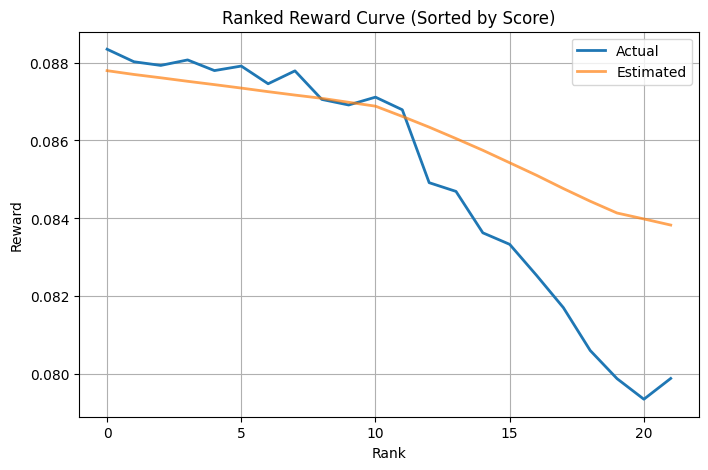

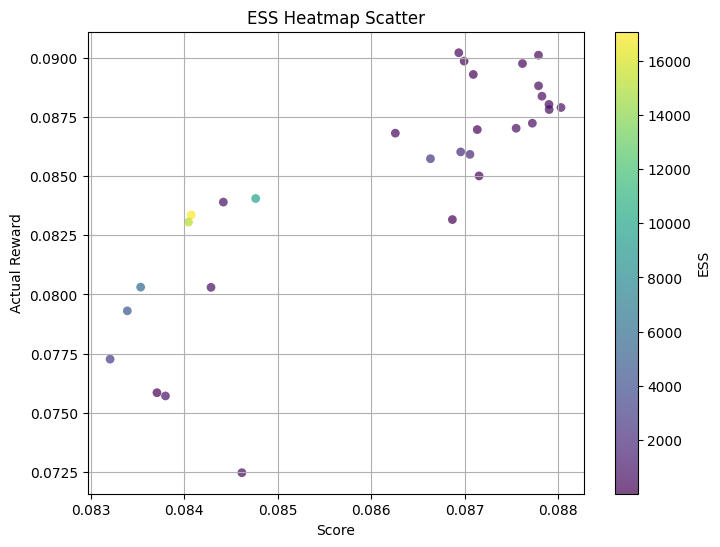

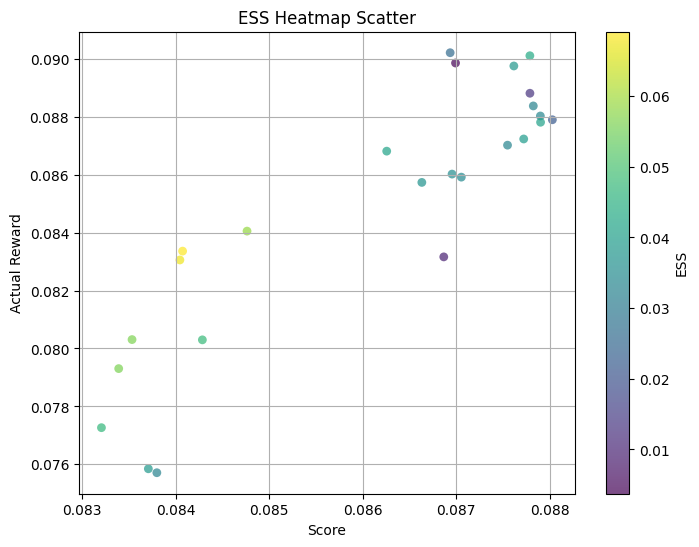

Correlation Metrics: {'pearson_score_actual': np.float64(0.8343759037157628), 'spearman_score_actual': np.float64(0.8020022246941045), 'spearman_est_actual': np.float64(0.8051167964404894)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9952175116499674), 'ndcg_est_actual': np.float64(0.9952444771418245)}
Error Metrics: {'mean_error': np.float64(-0.001763128662723827), 'mae': np.float64(0.0026088706602710385), 'rmse': np.float64(0.0038081888524449077), 'std_error': np.float64(0.0033754525110816407), 'max_error': np.float64(0.0030131822884151283), 'min_error': np.float64(-0.012235560668875364)}


In [ ]:
# study_df.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{12345}.csv")

compute_statistics_and_plots(study_df)

### Policy with delta function

In [ ]:
# dataset_params = dict(
#                     n_actions= n_actions,
#                     n_users = n_users,
#                     emb_dim = emb_dim,
#                     # sigma = 0.1,
#                     eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
#                     ctr = 0.1
#                     )

train_dataset = generate_dataset(dataset_params, seed=10000)

Random Item CTR: 0.07299616499379533
Optimal greedy CTR: 0.09999912765877851
Second Best greedy CTR: 0.09924234208905701
Optimal Stochastic CTR: 0.09986822971033672
second Best Stochastic CTR: 0.08585992378345159
Our Initial CTR: 0.08589106637164244


In [ ]:
# Run the optimization
df5, study_df5 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=100000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df5.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{100000}.csv")

# Show the performance metrics
df5[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 200000 samples: 2.9695651531219482 seconds
[Regression] Baseline regression model fit time: 0.33s
Num samples is 100000
{'gini': np.float64(0.4125446952435058), 'ess': np.float64(54194.00130745827), 'max_wi': np.float64(25.615993016803504), 'min_wi': np.float64(0.009995965102838693)}
Eval time: 36.08143162727356 seconds
Evaluation total results time: 67.54 seconds

=== [Regression] Training size 250000, run 0 ===


[I 2026-01-04 10:49:34,305] A new study created in memory with name: no-name-153cd264-7ac7-4851-a594-fedc1493abd0


Simulation time for 350000 samples: 4.3926684856414795 seconds


  0%|          | 0/30 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.09136863]


Best trial: 0. Best value: 0.0883776:   3%|▎         | 1/30 [00:35<17:06, 35.41s/it]

[I 2026-01-04 10:50:09,716] Trial 0 finished with value: 0.08837757720602346 and parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 1
actual reward: [0.08639099]


Best trial: 0. Best value: 0.0883776:   7%|▋         | 2/30 [00:40<08:18, 17.82s/it]

[I 2026-01-04 10:50:15,219] Trial 1 finished with value: 0.08357879821692782 and parameters: {'lr': 0.0018270275302660957, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9872789723014228}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 2
actual reward: [0.08625461]


Best trial: 0. Best value: 0.0883776:  10%|█         | 3/30 [01:16<11:39, 25.90s/it]

[I 2026-01-04 10:50:50,726] Trial 2 finished with value: 0.08440448588400884 and parameters: {'lr': 0.00010943160327463597, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8376908121795166}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 3
actual reward: [0.0893783]


Best trial: 0. Best value: 0.0883776:  13%|█▎        | 4/30 [01:32<09:31, 21.98s/it]

[I 2026-01-04 10:51:06,712] Trial 3 finished with value: 0.08743136223647865 and parameters: {'lr': 0.005895214868394568, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9512929465141857}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 4
actual reward: [0.08654805]


Best trial: 0. Best value: 0.0883776:  17%|█▋        | 5/30 [02:07<11:11, 26.85s/it]

[I 2026-01-04 10:51:42,195] Trial 4 finished with value: 0.08314451067365496 and parameters: {'lr': 0.0003849456433579582, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9671840350236083}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 5
actual reward: [0.07858424]


Best trial: 0. Best value: 0.0883776:  20%|██        | 6/30 [02:20<08:48, 22.01s/it]

[I 2026-01-04 10:51:54,820] Trial 5 finished with value: 0.08256508758104107 and parameters: {'lr': 0.08563241278753662, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8561647977835083}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 6
actual reward: [0.08616581]


Best trial: 0. Best value: 0.0883776:  23%|██▎       | 7/30 [02:32<07:08, 18.63s/it]

[I 2026-01-04 10:52:06,495] Trial 6 finished with value: 0.0823232575498155 and parameters: {'lr': 0.0013631726320981147, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9561379775639296}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 7
actual reward: [0.08636231]


Best trial: 0. Best value: 0.0883776:  27%|██▋       | 8/30 [02:43<05:57, 16.24s/it]

[I 2026-01-04 10:52:17,611] Trial 7 finished with value: 0.08412021743982444 and parameters: {'lr': 0.00030527920203576636, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.986873056747186}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 8
actual reward: [0.08633315]


Best trial: 0. Best value: 0.0883776:  30%|███       | 9/30 [03:06<06:25, 18.33s/it]

[I 2026-01-04 10:52:40,547] Trial 8 finished with value: 0.08420873138659274 and parameters: {'lr': 0.0001340328020976567, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.98174672698976}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 9
actual reward: [0.0811924]


Best trial: 0. Best value: 0.0883776:  33%|███▎      | 10/30 [03:12<04:51, 14.56s/it]

[I 2026-01-04 10:52:46,662] Trial 9 finished with value: 0.08204329198425485 and parameters: {'lr': 0.04288067243572375, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9765969757765852}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 10
actual reward: [0.09095586]


Best trial: 0. Best value: 0.0883776:  37%|███▋      | 11/30 [03:39<05:50, 18.43s/it]

[I 2026-01-04 10:53:13,870] Trial 10 finished with value: 0.08634757273138553 and parameters: {'lr': 0.010559875797439956, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9103440034035017}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 11
actual reward: [0.08800361]


Best trial: 0. Best value: 0.0883776:  40%|████      | 12/30 [03:55<05:19, 17.73s/it]

[I 2026-01-04 10:53:29,983] Trial 11 finished with value: 0.08830415601777684 and parameters: {'lr': 0.01105823136182145, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9266968607859147}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 12
actual reward: [0.08862888]


Best trial: 0. Best value: 0.0883776:  43%|████▎     | 13/30 [04:39<07:15, 25.59s/it]

[I 2026-01-04 10:54:13,670] Trial 12 finished with value: 0.08284148154902916 and parameters: {'lr': 0.017594359766939707, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9166103390600177}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 13
actual reward: [0.0890533]


Best trial: 0. Best value: 0.0883776:  47%|████▋     | 14/30 [04:53<05:55, 22.23s/it]

[I 2026-01-04 10:54:28,146] Trial 13 finished with value: 0.08174341758832183 and parameters: {'lr': 0.0036046572640227865, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8798197985683365}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 14
actual reward: [0.0860008]


Best trial: 0. Best value: 0.0883776:  50%|█████     | 15/30 [05:11<05:11, 20.79s/it]

[I 2026-01-04 10:54:45,605] Trial 14 finished with value: 0.0815836555778339 and parameters: {'lr': 0.0009607171357521699, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9406487642232867}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 15
actual reward: [0.0893818]


Best trial: 0. Best value: 0.0883776:  53%|█████▎    | 16/30 [05:42<05:36, 24.05s/it]

[I 2026-01-04 10:55:17,223] Trial 15 finished with value: 0.08305203692981895 and parameters: {'lr': 0.01805456637676037, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8084442511449323}. Best is trial 0 with value: 0.08837757720602346.

[Regression] Optuna Trial 16
actual reward: [0.09120012]


Best trial: 16. Best value: 0.0895908:  57%|█████▋    | 17/30 [06:07<05:16, 24.34s/it]

[I 2026-01-04 10:55:42,246] Trial 16 finished with value: 0.08959084748258132 and parameters: {'lr': 0.005418309003953338, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9232712471215323}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 17
actual reward: [0.0906828]


Best trial: 16. Best value: 0.0895908:  60%|██████    | 18/30 [06:35<05:03, 25.26s/it]

[I 2026-01-04 10:56:09,622] Trial 17 finished with value: 0.08725989596289674 and parameters: {'lr': 0.004205417090232096, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.8892583136914682}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 18
actual reward: [0.08623775]


Best trial: 16. Best value: 0.0895908:  63%|██████▎   | 19/30 [07:00<04:36, 25.14s/it]

[I 2026-01-04 10:56:34,492] Trial 18 finished with value: 0.08251525166941875 and parameters: {'lr': 0.0005349183217606818, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9343233839299585}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 19
actual reward: [0.08966968]


Best trial: 16. Best value: 0.0895908:  67%|██████▋   | 20/30 [07:17<03:48, 22.87s/it]

[I 2026-01-04 10:56:52,068] Trial 19 finished with value: 0.0853683055360097 and parameters: {'lr': 0.0021201430991910314, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9996100319825257}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 20
actual reward: [0.08631988]


Best trial: 16. Best value: 0.0895908:  70%|███████   | 21/30 [07:24<02:43, 18.11s/it]

[I 2026-01-04 10:56:59,088] Trial 20 finished with value: 0.08422663519987972 and parameters: {'lr': 0.0007664507932886701, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8996143078628374}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 21
actual reward: [0.0915914]


Best trial: 16. Best value: 0.0895908:  73%|███████▎  | 22/30 [08:04<03:17, 24.64s/it]

[I 2026-01-04 10:57:38,942] Trial 21 finished with value: 0.08697469704756232 and parameters: {'lr': 0.010387626959386886, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9254677276852272}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 22
actual reward: [0.09045782]


Best trial: 16. Best value: 0.0895908:  77%|███████▋  | 23/30 [08:24<02:42, 23.24s/it]

[I 2026-01-04 10:57:58,940] Trial 22 finished with value: 0.08872998842537996 and parameters: {'lr': 0.01005681888209635, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8672945789190507}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 23
actual reward: [0.08989558]


Best trial: 16. Best value: 0.0895908:  80%|████████  | 24/30 [08:44<02:13, 22.30s/it]

[I 2026-01-04 10:58:19,042] Trial 23 finished with value: 0.08859399008375686 and parameters: {'lr': 0.006125812726200541, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8643960162901452}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 24
actual reward: [0.08881949]


Best trial: 16. Best value: 0.0895908:  83%|████████▎ | 25/30 [09:04<01:48, 21.64s/it]

[I 2026-01-04 10:58:39,126] Trial 24 finished with value: 0.08551717798045122 and parameters: {'lr': 0.0263741373593153, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.865468672198968}. Best is trial 16 with value: 0.08959084748258132.

[Regression] Optuna Trial 25
actual reward: [0.08954904]


Best trial: 25. Best value: 0.0902227:  87%|████████▋ | 26/30 [09:22<01:21, 20.43s/it]

[I 2026-01-04 10:58:56,757] Trial 25 finished with value: 0.09022270634571133 and parameters: {'lr': 0.007302056354651622, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8343990421424431}. Best is trial 25 with value: 0.09022270634571133.

[Regression] Optuna Trial 26
actual reward: [0.08329417]


Best trial: 25. Best value: 0.0902227:  90%|█████████ | 27/30 [09:35<00:54, 18.11s/it]

[I 2026-01-04 10:59:09,448] Trial 26 finished with value: 0.08355652376196471 and parameters: {'lr': 0.04135725631756566, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8257916470373178}. Best is trial 25 with value: 0.09022270634571133.

[Regression] Optuna Trial 27
actual reward: [0.08990664]


Best trial: 25. Best value: 0.0902227:  93%|█████████▎| 28/30 [09:52<00:36, 18.00s/it]

[I 2026-01-04 10:59:27,197] Trial 27 finished with value: 0.08995675334541593 and parameters: {'lr': 0.00762836994687486, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8445057466726935}. Best is trial 25 with value: 0.09022270634571133.

[Regression] Optuna Trial 28
actual reward: [0.08514378]


Best trial: 25. Best value: 0.0902227:  97%|█████████▋| 29/30 [09:58<00:14, 14.16s/it]

[I 2026-01-04 10:59:32,401] Trial 28 finished with value: 0.08215014556518051 and parameters: {'lr': 0.004542918595096549, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.835161113954931}. Best is trial 25 with value: 0.09022270634571133.

[Regression] Optuna Trial 29
actual reward: [0.08781328]


Best trial: 25. Best value: 0.0902227: 100%|██████████| 30/30 [10:10<00:00, 20.35s/it]


[I 2026-01-04 10:59:44,846] Trial 29 finished with value: 0.0835514630617558 and parameters: {'lr': 0.002807661265443379, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8181137669409801}. Best is trial 25 with value: 0.09022270634571133.
Num samples is 100000
{'gini': np.float64(0.9948244005497492), 'ess': np.float64(108.0446136577651), 'max_wi': np.float64(4454.032016111014), 'min_wi': np.float64(2.0429332565944305e-11)}
Eval time: 33.85882830619812 seconds
Evaluation total results time: 64.76 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08589107,0.08729000,0.08847519,0.08847519,0.08727182,0.08727182,0.76670009,0.00000000,0.83964109,0.00000000
250000,0.08914573,0.06047118,0.08530101,0.08530101,0.05926623,0.05972741,0.93544951,0.41971851,1.07626387,0.43378664


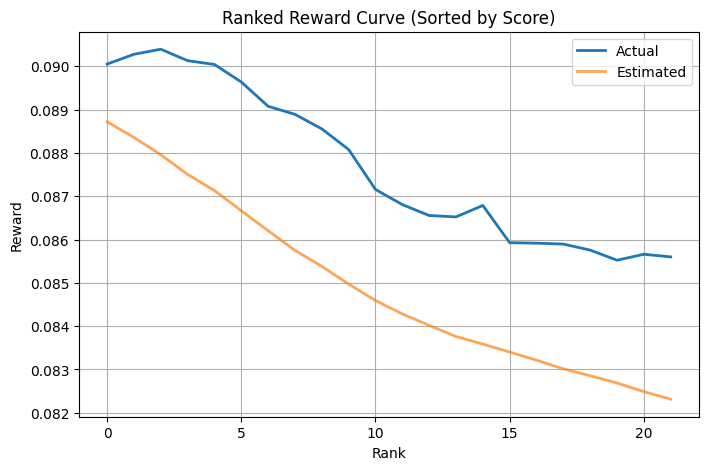

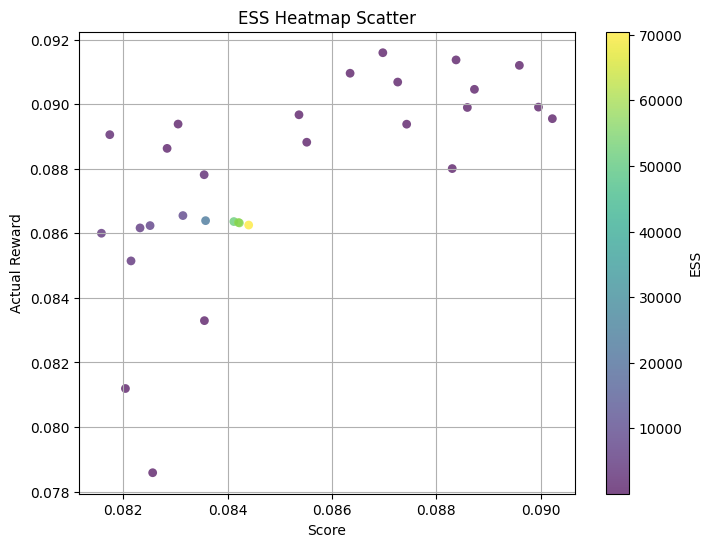

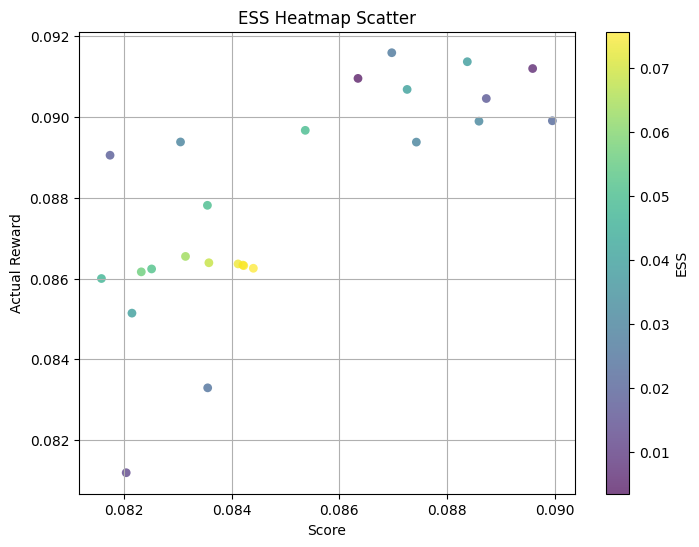

Correlation Metrics: {'pearson_score_actual': np.float64(0.664989032135445), 'spearman_score_actual': np.float64(0.7423804226918799), 'spearman_est_actual': np.float64(0.7486095661846496)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9965517717819093), 'ndcg_est_actual': np.float64(0.9966220921854736)}
Error Metrics: {'mean_error': np.float64(0.00217137515861751), 'mae': np.float64(0.0026405987674196474), 'rmse': np.float64(0.003177371856059052), 'std_error': np.float64(0.0023196598526971416), 'max_error': np.float64(0.007041576379337139), 'min_error': np.float64(-0.004033282742075983)}


In [ ]:
compute_statistics_and_plots(study_df5)

In [ ]:
# dataset_params = dict(
#                     n_actions= n_actions,
#                     n_users = n_users,
#                     emb_dim = 12,
#                     # sigma = 0.1,
#                     eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
#                     ctr = 0.1
#                     )

train_dataset = generate_dataset(dataset_params, seed=20000)

Random Item CTR: 0.07309055792320392
Optimal greedy CTR: 0.09999897086664764
Second Best greedy CTR: 0.09970300652604132
Optimal Stochastic CTR: 0.09986439645169445
second Best Stochastic CTR: 0.0859222902219525
Our Initial CTR: 0.08595116402443975


In [ ]:
# Run the optimization
df6, study_df6 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=100000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df6.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{20000}.csv")
# Show the performance metrics
df6[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 200000 samples: 2.5389957427978516 seconds
[Regression] Baseline regression model fit time: 0.21s
Num samples is 100000
{'gini': np.float64(0.41103650434369166), 'ess': np.float64(52716.14511374075), 'max_wi': np.float64(35.67599317713186), 'min_wi': np.float64(0.008284436378410663)}
Eval time: 34.09753441810608 seconds
Evaluation total results time: 64.84 seconds

=== [Regression] Training size 250000, run 0 ===


[I 2026-01-04 11:02:14,619] A new study created in memory with name: no-name-ae574382-3ca2-4905-b5e8-f21e60af881b


Simulation time for 350000 samples: 4.395092964172363 seconds


  0%|          | 0/30 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.09363027]


Best trial: 0. Best value: 0.0855886:   3%|▎         | 1/30 [00:35<17:13, 35.64s/it]

[I 2026-01-04 11:02:50,254] Trial 0 finished with value: 0.08558857686735306 and parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 1
actual reward: [0.08292874]


Best trial: 0. Best value: 0.0855886:   7%|▋         | 2/30 [00:42<08:47, 18.82s/it]

[I 2026-01-04 11:02:57,311] Trial 1 finished with value: 0.08296120857023544 and parameters: {'lr': 0.09013423754425866, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.894036279084838}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 2
actual reward: [0.09245167]


Best trial: 0. Best value: 0.0855886:  10%|█         | 3/30 [00:55<07:13, 16.04s/it]

[I 2026-01-04 11:03:10,045] Trial 2 finished with value: 0.08298435129520502 and parameters: {'lr': 0.036772762472573384, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.817585348913679}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 3
actual reward: [0.08615229]


Best trial: 0. Best value: 0.0855886:  13%|█▎        | 4/30 [01:08<06:26, 14.86s/it]

[I 2026-01-04 11:03:23,080] Trial 3 finished with value: 0.08477350580971842 and parameters: {'lr': 0.0001157546147455195, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9531802239195943}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 4
actual reward: [0.08620572]


Best trial: 0. Best value: 0.0855886:  17%|█▋        | 5/30 [01:21<05:51, 14.05s/it]

[I 2026-01-04 11:03:35,707] Trial 4 finished with value: 0.08310152580726726 and parameters: {'lr': 0.04717087061134012, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8610878865117106}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 5
actual reward: [0.08648856]


Best trial: 0. Best value: 0.0855886:  20%|██        | 6/30 [01:36<05:44, 14.36s/it]

[I 2026-01-04 11:03:50,669] Trial 5 finished with value: 0.08466149791815675 and parameters: {'lr': 0.00020365735395434085, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8668424618080992}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 6
actual reward: [0.08618422]


Best trial: 0. Best value: 0.0855886:  23%|██▎       | 7/30 [01:43<04:39, 12.16s/it]

[I 2026-01-04 11:03:58,291] Trial 6 finished with value: 0.08476044391963995 and parameters: {'lr': 0.00019624399601446036, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.8685853564367996}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 7
actual reward: [0.09309663]


Best trial: 0. Best value: 0.0855886:  27%|██▋       | 8/30 [02:08<05:56, 16.23s/it]

[I 2026-01-04 11:04:23,224] Trial 7 finished with value: 0.08450389936091708 and parameters: {'lr': 0.01413288281217453, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8418607020016358}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 8
actual reward: [0.09303694]


Best trial: 0. Best value: 0.0855886:  30%|███       | 9/30 [02:52<08:42, 24.89s/it]

[I 2026-01-04 11:05:07,177] Trial 8 finished with value: 0.08523817663835896 and parameters: {'lr': 0.002946704967757138, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8119913878455819}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 9
actual reward: [0.0862157]


Best trial: 0. Best value: 0.0855886:  33%|███▎      | 10/30 [03:03<06:53, 20.65s/it]

[I 2026-01-04 11:05:18,337] Trial 9 finished with value: 0.08475171734574413 and parameters: {'lr': 0.00011871007911626979, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9902732926773604}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 10
actual reward: [0.08734051]


Best trial: 0. Best value: 0.0855886:  37%|███▋      | 11/30 [03:10<05:12, 16.43s/it]

[I 2026-01-04 11:05:25,190] Trial 10 finished with value: 0.0843333174444114 and parameters: {'lr': 0.0014857391132526497, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9452182084158526}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 11
actual reward: [0.09237573]


Best trial: 0. Best value: 0.0855886:  40%|████      | 12/30 [03:54<07:24, 24.72s/it]

[I 2026-01-04 11:06:08,868] Trial 11 finished with value: 0.08448144472781174 and parameters: {'lr': 0.0023521553251888757, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8012713448372839}. Best is trial 0 with value: 0.08558857686735306.

[Regression] Optuna Trial 12
actual reward: [0.09448091]


Best trial: 12. Best value: 0.0858063:  43%|████▎     | 13/30 [04:33<08:16, 29.20s/it]

[I 2026-01-04 11:06:48,367] Trial 12 finished with value: 0.08580633494649392 and parameters: {'lr': 0.006755189080256751, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9242077659033117}. Best is trial 12 with value: 0.08580633494649392.

[Regression] Optuna Trial 13
actual reward: [0.09383453]


Best trial: 12. Best value: 0.0858063:  47%|████▋     | 14/30 [05:09<08:17, 31.12s/it]

[I 2026-01-04 11:07:23,930] Trial 13 finished with value: 0.08488991734291858 and parameters: {'lr': 0.008637496207791369, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9305521976489914}. Best is trial 12 with value: 0.08580633494649392.

[Regression] Optuna Trial 14
actual reward: [0.09016351]


Best trial: 12. Best value: 0.0858063:  50%|█████     | 15/30 [05:44<08:05, 32.34s/it]

[I 2026-01-04 11:07:59,112] Trial 14 finished with value: 0.08387621799215457 and parameters: {'lr': 0.0007521087605148642, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9987466789901209}. Best is trial 12 with value: 0.08580633494649392.

[Regression] Optuna Trial 15
actual reward: [0.0939382]


Best trial: 12. Best value: 0.0858063:  53%|█████▎    | 16/30 [06:24<08:03, 34.51s/it]

[I 2026-01-04 11:08:38,658] Trial 15 finished with value: 0.08497407592609243 and parameters: {'lr': 0.0069540138266495684, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9693744889057743}. Best is trial 12 with value: 0.08580633494649392.

[Regression] Optuna Trial 16
actual reward: [0.09116119]


Best trial: 12. Best value: 0.0858063:  57%|█████▋    | 17/30 [06:59<07:30, 34.68s/it]

[I 2026-01-04 11:09:13,738] Trial 16 finished with value: 0.08424933699734605 and parameters: {'lr': 0.0012616463102917677, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9117928334540025}. Best is trial 12 with value: 0.08580633494649392.

[Regression] Optuna Trial 17
actual reward: [0.08833072]


Best trial: 12. Best value: 0.0858063:  60%|██████    | 18/30 [07:26<06:29, 32.48s/it]

[I 2026-01-04 11:09:41,090] Trial 17 finished with value: 0.08414843997561816 and parameters: {'lr': 0.0005239444503274594, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9749721601107744}. Best is trial 12 with value: 0.08580633494649392.

[Regression] Optuna Trial 18
actual reward: [0.09268596]


Best trial: 18. Best value: 0.0866644:  63%|██████▎   | 19/30 [07:51<05:31, 30.17s/it]

[I 2026-01-04 11:10:05,868] Trial 18 finished with value: 0.08666435262138027 and parameters: {'lr': 0.0056913837319621016, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9180748917436221}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 19
actual reward: [0.09217246]


Best trial: 18. Best value: 0.0866644:  67%|██████▋   | 20/30 [08:18<04:53, 29.36s/it]

[I 2026-01-04 11:10:33,344] Trial 19 finished with value: 0.08391059574002672 and parameters: {'lr': 0.013962954272347517, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9121251271249113}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 20
actual reward: [0.09207617]


Best trial: 18. Best value: 0.0866644:  70%|███████   | 21/30 [08:31<03:38, 24.31s/it]

[I 2026-01-04 11:10:45,885] Trial 20 finished with value: 0.08435221913741489 and parameters: {'lr': 0.005008916044531754, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8862913050349097}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 21
actual reward: [0.09315416]


Best trial: 18. Best value: 0.0866644:  73%|███████▎  | 22/30 [08:56<03:15, 24.45s/it]

[I 2026-01-04 11:11:10,644] Trial 21 finished with value: 0.0842465751787473 and parameters: {'lr': 0.0044984727771352475, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.937718689094823}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 22
actual reward: [0.09088662]


Best trial: 18. Best value: 0.0866644:  77%|███████▋  | 23/30 [09:16<02:41, 23.13s/it]

[I 2026-01-04 11:11:30,696] Trial 22 finished with value: 0.08397246915294347 and parameters: {'lr': 0.016452127880428408, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9664298767367725}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 23
actual reward: [0.09335062]


Best trial: 18. Best value: 0.0866644:  80%|████████  | 24/30 [09:55<02:47, 27.99s/it]

[I 2026-01-04 11:12:10,044] Trial 23 finished with value: 0.08541404966776768 and parameters: {'lr': 0.0019738400047954485, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9218521234609469}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 24
actual reward: [0.08910142]


Best trial: 18. Best value: 0.0866644:  83%|████████▎ | 25/30 [10:30<02:30, 30.18s/it]

[I 2026-01-04 11:12:45,313] Trial 24 finished with value: 0.08398186328305686 and parameters: {'lr': 0.0006357499414106217, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9555815468055552}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 25
actual reward: [0.08941802]


Best trial: 18. Best value: 0.0866644:  87%|████████▋ | 26/30 [10:58<01:57, 29.34s/it]

[I 2026-01-04 11:13:12,706] Trial 25 finished with value: 0.08359577380696002 and parameters: {'lr': 0.02691828961004572, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9044863842050104}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 26
actual reward: [0.09142946]


Best trial: 18. Best value: 0.0866644:  90%|█████████ | 27/30 [11:11<01:13, 24.46s/it]

[I 2026-01-04 11:13:25,779] Trial 26 finished with value: 0.08338387408431705 and parameters: {'lr': 0.00806147841838304, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9854362757952327}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 27
actual reward: [0.09287828]


Best trial: 18. Best value: 0.0866644:  93%|█████████▎| 28/30 [11:28<00:44, 22.44s/it]

[I 2026-01-04 11:13:43,494] Trial 27 finished with value: 0.08331044269545883 and parameters: {'lr': 0.00440429897325801, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9247857003642801}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 28
actual reward: [0.09043003]


Best trial: 18. Best value: 0.0866644:  97%|█████████▋| 29/30 [12:04<00:26, 26.31s/it]

[I 2026-01-04 11:14:18,855] Trial 28 finished with value: 0.08399890254417942 and parameters: {'lr': 0.0011491329466413848, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8953423161935874}. Best is trial 18 with value: 0.08666435262138027.

[Regression] Optuna Trial 29
actual reward: [0.08534535]


Best trial: 18. Best value: 0.0866644: 100%|██████████| 30/30 [12:15<00:00, 24.52s/it]


[I 2026-01-04 11:14:30,224] Trial 29 finished with value: 0.08275632880443827 and parameters: {'lr': 0.075111604622187, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8805872291366569}. Best is trial 18 with value: 0.08666435262138027.
Num samples is 100000
{'gini': np.float64(0.996382893358847), 'ess': np.float64(59.4247194344276), 'max_wi': np.float64(11986.49201083084), 'min_wi': np.float64(3.707259606272663e-11)}
Eval time: 34.30289435386658 seconds
Evaluation total results time: 65.63 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08595116,0.08747000,0.08833187,0.08833187,0.08746385,0.08746385,0.85294565,0.00000000,0.75313426,0.00000000
250000,0.09242560,0.08297206,0.08497145,0.08497145,0.08242446,0.08263569,1.10627095,0.50191457,1.01896067,0.55800202


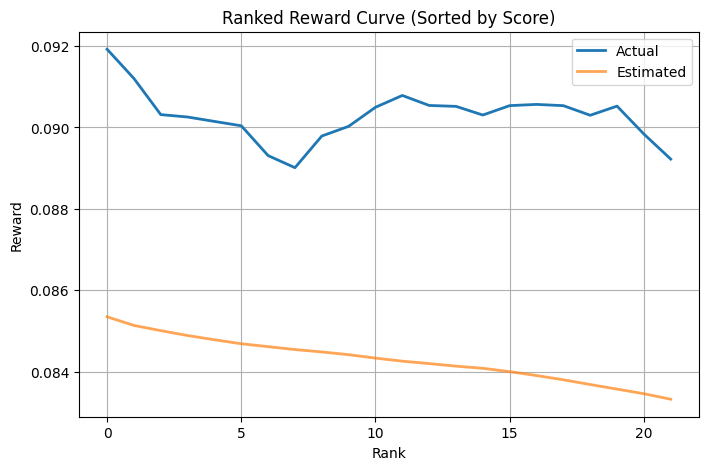

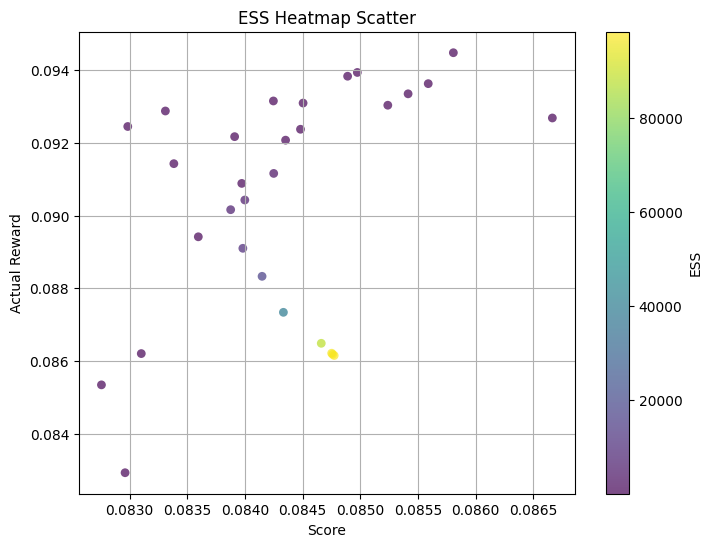

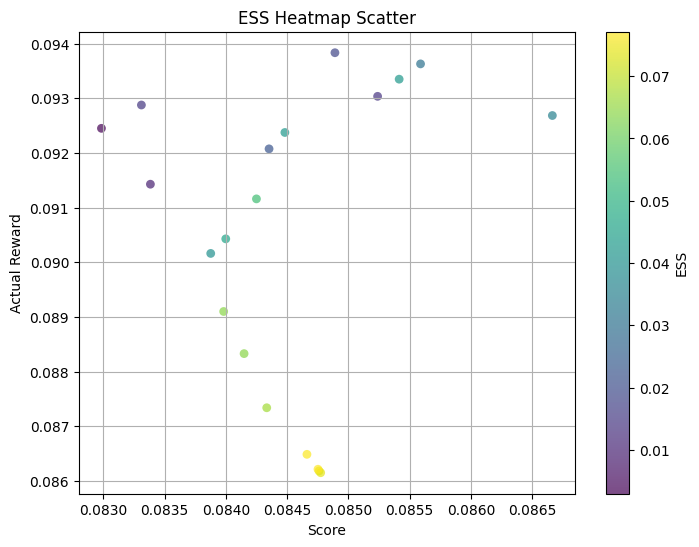

Correlation Metrics: {'pearson_score_actual': np.float64(0.44201960088441666), 'spearman_score_actual': np.float64(0.4923248053392658), 'spearman_est_actual': np.float64(0.19288097886540603)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9957824519931688), 'ndcg_est_actual': np.float64(0.9884394657331836)}
Error Metrics: {'mean_error': np.float64(0.005607838812160635), 'mae': np.float64(0.005615030265214971), 'rmse': np.float64(0.006404737266585986), 'std_error': np.float64(0.003093994717322593), 'max_error': np.float64(0.009336435308416144), 'min_error': np.float64(-0.00010787179581502049)}


In [ ]:
compute_statistics_and_plots(study_df6)

In [ ]:
# dataset_params = dict(
#                     n_actions= n_actions,
#                     n_users = n_users,
#                     emb_dim = emb_dim,
#                     # sigma = 0.1,
#                     eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
#                     ctr = 0.1
#                     )

train_dataset = generate_dataset(dataset_params, seed=30000)

Random Item CTR: 0.07291694007324749
Optimal greedy CTR: 0.09999912629257961
Second Best greedy CTR: 0.09724450569070416
Optimal Stochastic CTR: 0.09987205538704724
second Best Stochastic CTR: 0.08585387614135936
Our Initial CTR: 0.08588514142470695


In [ ]:
# Run the optimization
df7, study_df7 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=80000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df7.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{30000}.csv")
# Show the performance metrics
df7[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 160000 samples: 2.1111598014831543 seconds
[Regression] Baseline regression model fit time: 0.28s
Num samples is 80000
{'gini': np.float64(0.42276891273592854), 'ess': np.float64(39441.331642314784), 'max_wi': np.float64(90.54077420063948), 'min_wi': np.float64(0.01493015702876215)}
Eval time: 28.504249334335327 seconds
Evaluation total results time: 53.48 seconds

=== [Regression] Training size 250000, run 0 ===


[I 2026-01-04 11:16:55,441] A new study created in memory with name: no-name-ab636026-0b0b-4bd4-8cdf-f6f941f5bdd0


Simulation time for 330000 samples: 4.144139051437378 seconds


  0%|          | 0/30 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.09092317]


Best trial: 0. Best value: 0.0864382:   3%|▎         | 1/30 [00:35<17:10, 35.52s/it]

[I 2026-01-04 11:17:30,961] Trial 0 finished with value: 0.08643822128393501 and parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98}. Best is trial 0 with value: 0.08643822128393501.

[Regression] Optuna Trial 1
actual reward: [0.0861938]


Best trial: 0. Best value: 0.0864382:   7%|▋         | 2/30 [00:51<11:09, 23.92s/it]

[I 2026-01-04 11:17:46,766] Trial 1 finished with value: 0.08420166677541298 and parameters: {'lr': 0.0001245321967669912, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9538240007352199}. Best is trial 0 with value: 0.08643822128393501.

[Regression] Optuna Trial 2
actual reward: [0.08642238]


Best trial: 0. Best value: 0.0864382:  10%|█         | 3/30 [00:57<07:12, 16.02s/it]

[I 2026-01-04 11:17:53,390] Trial 2 finished with value: 0.08407520669322127 and parameters: {'lr': 0.0007115930780190277, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9137047761179018}. Best is trial 0 with value: 0.08643822128393501.

[Regression] Optuna Trial 3
actual reward: [0.07833553]


Best trial: 0. Best value: 0.0864382:  13%|█▎        | 4/30 [01:04<05:24, 12.48s/it]

[I 2026-01-04 11:18:00,437] Trial 3 finished with value: 0.08329781082510815 and parameters: {'lr': 0.09855397288194674, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8878238886122075}. Best is trial 0 with value: 0.08643822128393501.

[Regression] Optuna Trial 4
actual reward: [0.08690563]


Best trial: 0. Best value: 0.0864382:  17%|█▋        | 5/30 [01:22<05:54, 14.20s/it]

[I 2026-01-04 11:18:17,684] Trial 4 finished with value: 0.08396939344298683 and parameters: {'lr': 0.0010927269273486079, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.859218121401063}. Best is trial 0 with value: 0.08643822128393501.

[Regression] Optuna Trial 5
actual reward: [0.08536375]


Best trial: 0. Best value: 0.0864382:  20%|██        | 6/30 [01:27<04:29, 11.23s/it]

[I 2026-01-04 11:18:23,163] Trial 5 finished with value: 0.083778115989813 and parameters: {'lr': 0.03622223826514197, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8968357449737602}. Best is trial 0 with value: 0.08643822128393501.

[Regression] Optuna Trial 6
actual reward: [0.08592331]


Best trial: 0. Best value: 0.0864382:  23%|██▎       | 7/30 [01:46<05:13, 13.64s/it]

[I 2026-01-04 11:18:41,757] Trial 6 finished with value: 0.08307888264423746 and parameters: {'lr': 0.02511455809300771, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8157608505287239}. Best is trial 0 with value: 0.08643822128393501.

[Regression] Optuna Trial 7
actual reward: [0.0888876]


Best trial: 7. Best value: 0.086767:  27%|██▋       | 8/30 [02:03<05:27, 14.87s/it] 

[I 2026-01-04 11:18:59,271] Trial 7 finished with value: 0.08676702463520425 and parameters: {'lr': 0.0066245933868356414, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9724276452082328}. Best is trial 7 with value: 0.08676702463520425.

[Regression] Optuna Trial 8
actual reward: [0.08970357]


Best trial: 7. Best value: 0.086767:  30%|███       | 9/30 [02:13<04:40, 13.38s/it]

[I 2026-01-04 11:19:09,363] Trial 8 finished with value: 0.08607138313874613 and parameters: {'lr': 0.009762504526051527, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.9943691924277289}. Best is trial 7 with value: 0.08676702463520425.

[Regression] Optuna Trial 9
actual reward: [0.08350341]


Best trial: 7. Best value: 0.086767:  33%|███▎      | 10/30 [02:23<04:01, 12.09s/it]

[I 2026-01-04 11:19:18,575] Trial 9 finished with value: 0.08391137001620994 and parameters: {'lr': 0.0706963745125034, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9141751547595773}. Best is trial 7 with value: 0.08676702463520425.

[Regression] Optuna Trial 10
actual reward: [0.08674285]


Best trial: 10. Best value: 0.0875318:  37%|███▋      | 11/30 [02:37<04:01, 12.71s/it]

[I 2026-01-04 11:19:32,697] Trial 10 finished with value: 0.08753183477293185 and parameters: {'lr': 0.008479407123161715, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9464779746184603}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 11
actual reward: [0.08601559]


Best trial: 10. Best value: 0.0875318:  40%|████      | 12/30 [02:51<03:55, 13.11s/it]

[I 2026-01-04 11:19:46,713] Trial 11 finished with value: 0.08739908206824377 and parameters: {'lr': 0.007810308258990984, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9513366172402423}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 12
actual reward: [0.08712185]


Best trial: 10. Best value: 0.0875318:  43%|████▎     | 13/30 [03:03<03:39, 12.89s/it]

[I 2026-01-04 11:19:59,090] Trial 12 finished with value: 0.08716412657980692 and parameters: {'lr': 0.009750480410596224, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9418308009236015}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 13
actual reward: [0.08791605]


Best trial: 10. Best value: 0.0875318:  47%|████▋     | 14/30 [03:16<03:23, 12.74s/it]

[I 2026-01-04 11:20:11,488] Trial 13 finished with value: 0.08375345564279536 and parameters: {'lr': 0.0025443449221156916, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9442843829014428}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 14
actual reward: [0.09018785]


Best trial: 10. Best value: 0.0875318:  50%|█████     | 15/30 [03:35<03:43, 14.90s/it]

[I 2026-01-04 11:20:31,389] Trial 14 finished with value: 0.08615112587489857 and parameters: {'lr': 0.015057471491963235, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9425712658429561}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 15
actual reward: [0.08835669]


Best trial: 10. Best value: 0.0875318:  53%|█████▎    | 16/30 [03:46<03:11, 13.67s/it]

[I 2026-01-04 11:20:42,213] Trial 15 finished with value: 0.08423556322670604 and parameters: {'lr': 0.00463309999757775, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8564982801032649}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 16
actual reward: [0.08682972]


Best trial: 10. Best value: 0.0875318:  57%|█████▋    | 17/30 [04:00<02:59, 13.78s/it]

[I 2026-01-04 11:20:56,252] Trial 16 finished with value: 0.08397475892490344 and parameters: {'lr': 0.0007317817978530616, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9236036972497704}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 17
actual reward: [0.08719559]


Best trial: 10. Best value: 0.0875318:  60%|██████    | 18/30 [04:20<03:05, 15.49s/it]

[I 2026-01-04 11:21:15,705] Trial 17 finished with value: 0.08478587031237951 and parameters: {'lr': 0.02974592984773064, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9696430948698274}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 18
actual reward: [0.08658714]


Best trial: 10. Best value: 0.0875318:  63%|██████▎   | 19/30 [04:42<03:12, 17.51s/it]

[I 2026-01-04 11:21:37,935] Trial 18 finished with value: 0.08404532349164041 and parameters: {'lr': 0.00017129041011459077, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9984753160795764}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 19
actual reward: [0.08667634]


Best trial: 10. Best value: 0.0875318:  67%|██████▋   | 20/30 [04:53<02:35, 15.53s/it]

[I 2026-01-04 11:21:48,839] Trial 19 finished with value: 0.08390164683502203 and parameters: {'lr': 0.0013544750845362827, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.870806559357562}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 20
actual reward: [0.08801768]


Best trial: 10. Best value: 0.0875318:  70%|███████   | 21/30 [05:07<02:15, 15.09s/it]

[I 2026-01-04 11:22:02,898] Trial 20 finished with value: 0.08398407022343797 and parameters: {'lr': 0.003959900620837484, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.809301044418425}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 21
actual reward: [0.08781432]


Best trial: 10. Best value: 0.0875318:  73%|███████▎  | 22/30 [05:20<01:54, 14.34s/it]

[I 2026-01-04 11:22:15,481] Trial 21 finished with value: 0.08595675692757097 and parameters: {'lr': 0.012638874959678829, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9281527403361713}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 22
actual reward: [0.0882807]


Best trial: 10. Best value: 0.0875318:  77%|███████▋  | 23/30 [05:32<01:36, 13.82s/it]

[I 2026-01-04 11:22:28,094] Trial 22 finished with value: 0.08748329760219034 and parameters: {'lr': 0.00663704905612651, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.960730313660211}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 23
actual reward: [0.08734102]


Best trial: 10. Best value: 0.0875318:  80%|████████  | 24/30 [05:46<01:23, 13.88s/it]

[I 2026-01-04 11:22:42,109] Trial 23 finished with value: 0.08701346235813892 and parameters: {'lr': 0.005369483957275569, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9636806337612918}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 24
actual reward: [0.08688709]


Best trial: 10. Best value: 0.0875318:  83%|████████▎ | 25/30 [06:04<01:15, 15.01s/it]

[I 2026-01-04 11:22:59,767] Trial 24 finished with value: 0.0847843126439123 and parameters: {'lr': 0.018935250836064645, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9828785602338016}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 25
actual reward: [0.08655467]


Best trial: 10. Best value: 0.0875318:  87%|████████▋ | 26/30 [06:15<00:55, 13.76s/it]

[I 2026-01-04 11:23:10,593] Trial 25 finished with value: 0.0836800807759617 and parameters: {'lr': 0.0018439532263194768, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9537492574885521}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 26
actual reward: [0.08555988]


Best trial: 10. Best value: 0.0875318:  90%|█████████ | 27/30 [06:31<00:43, 14.46s/it]

[I 2026-01-04 11:23:26,681] Trial 26 finished with value: 0.08270866720600534 and parameters: {'lr': 0.04646802870142878, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9321392213983768}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 27
actual reward: [0.09037125]


Best trial: 10. Best value: 0.0875318:  93%|█████████▎| 28/30 [06:48<00:30, 15.35s/it]

[I 2026-01-04 11:23:44,131] Trial 27 finished with value: 0.08677394169890322 and parameters: {'lr': 0.007506298370556574, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9556517901213979}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 28
actual reward: [0.08687623]


Best trial: 10. Best value: 0.0875318:  97%|█████████▋| 29/30 [07:23<00:21, 21.23s/it]

[I 2026-01-04 11:24:19,069] Trial 28 finished with value: 0.08408053871582433 and parameters: {'lr': 0.0003941895288510788, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9174178333323093}. Best is trial 10 with value: 0.08753183477293185.

[Regression] Optuna Trial 29
actual reward: [0.09158083]


Best trial: 10. Best value: 0.0875318: 100%|██████████| 30/30 [07:58<00:00, 15.95s/it]


[I 2026-01-04 11:24:54,033] Trial 29 finished with value: 0.08597516834440079 and parameters: {'lr': 0.0028511697937857175, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9816982765390773}. Best is trial 10 with value: 0.08753183477293185.
Num samples is 80000
{'gini': np.float64(0.9975377886511231), 'ess': np.float64(31.620929843867806), 'max_wi': np.float64(9857.071177825266), 'min_wi': np.float64(2.3354617020392347e-13)}
Eval time: 27.67410945892334 seconds
Evaluation total results time: 52.54 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08588514,0.08595000,0.08737445,0.08737445,0.08595923,0.08595923,0.74312065,0.00000000,0.81966391,0.00000000
250000,0.08847580,0.05351079,0.08646778,0.08646778,0.05453972,0.05345479,0.92992574,0.50149700,1.16463175,0.58406784


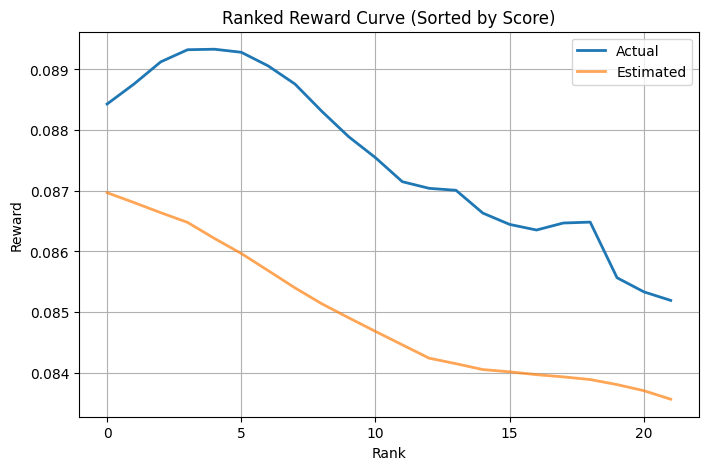

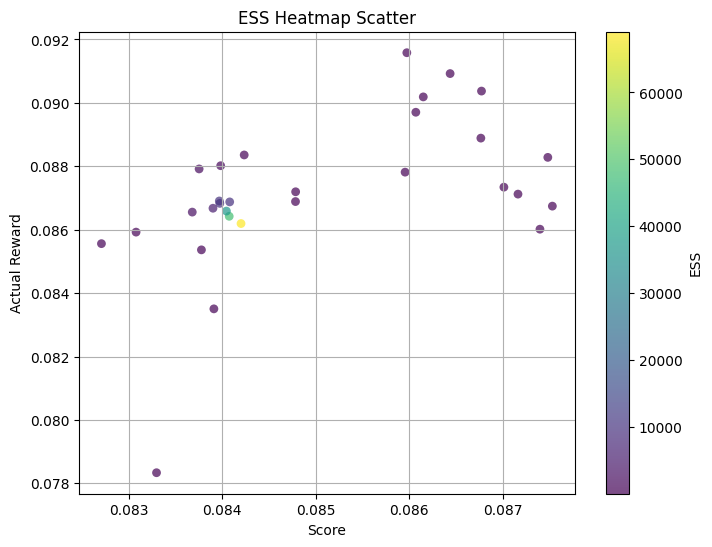

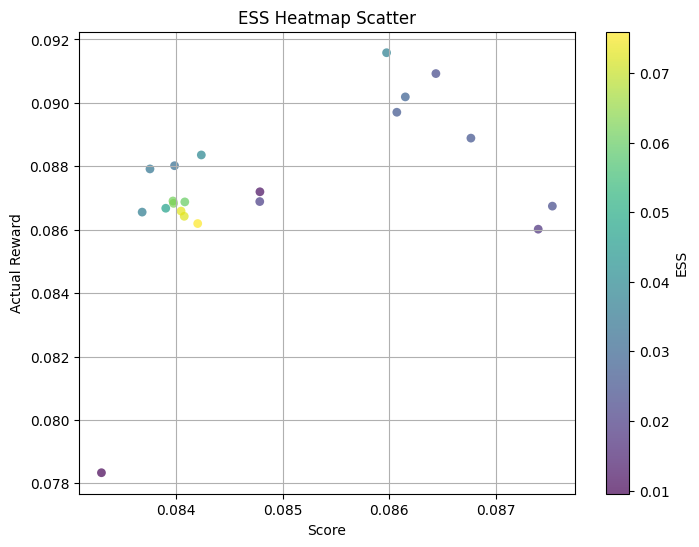

Correlation Metrics: {'pearson_score_actual': np.float64(0.5042808282401985), 'spearman_score_actual': np.float64(0.578642936596218), 'spearman_est_actual': np.float64(0.5279199110122358)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.992157534607615), 'ndcg_est_actual': np.float64(0.9920925401712317)}
Error Metrics: {'mean_error': np.float64(0.0017465907146017627), 'mae': np.float64(0.0023037332152972636), 'rmse': np.float64(0.0026766616998448976), 'std_error': np.float64(0.0020282846770321664), 'max_error': np.float64(0.005307093857296663), 'min_error': np.float64(-0.00503208765712361)}


In [ ]:
compute_statistics_and_plots(study_df7)

In [ ]:
# dataset_params = dict(
#                     n_actions= 2000,
#                     n_users = 2000,
#                     emb_dim = 12,
#                     # sigma = 0.1,
#                     eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
#                     ctr = 0.1
#                     )

train_dataset = generate_dataset(dataset_params, seed=40000)

Random Item CTR: 0.07308232681176861
Optimal greedy CTR: 0.0999990548267266
Second Best greedy CTR: 0.09762368115504418
Optimal Stochastic CTR: 0.09985850946040746
second Best Stochastic CTR: 0.08550862146517685
Our Initial CTR: 0.08553621872917394


In [ ]:
# Run the optimization
df8, study_df8 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=80000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df8.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{40000}.csv")
# Show the performance metrics
df8[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 160000 samples: 2.073413133621216 seconds
[Regression] Baseline regression model fit time: 0.38s
Num samples is 80000
{'gini': np.float64(0.41413190202081634), 'ess': np.float64(42195.313239496245), 'max_wi': np.float64(28.136123300175946), 'min_wi': np.float64(0.011826056620047602)}
Eval time: 28.130189657211304 seconds
Evaluation total results time: 53.14 seconds

=== [Regression] Training size 250000, run 0 ===


[I 2026-01-04 11:27:02,139] A new study created in memory with name: no-name-6f737fa3-5cde-4c0b-8c85-96ae0cb86fd4


Simulation time for 330000 samples: 4.153632640838623 seconds


  0%|          | 0/30 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.09179286]


Best trial: 0. Best value: 0.0870354:   3%|▎         | 1/30 [00:35<17:03, 35.28s/it]

[I 2026-01-04 11:27:37,417] Trial 0 finished with value: 0.08703544789055408 and parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98}. Best is trial 0 with value: 0.08703544789055408.

[Regression] Optuna Trial 1
actual reward: [0.08756385]


Best trial: 0. Best value: 0.0870354:   7%|▋         | 2/30 [00:51<11:08, 23.88s/it]

[I 2026-01-04 11:27:53,321] Trial 1 finished with value: 0.08271047766686336 and parameters: {'lr': 0.0346676502054522, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9101973027671377}. Best is trial 0 with value: 0.08703544789055408.

[Regression] Optuna Trial 2
actual reward: [0.07916537]


Best trial: 0. Best value: 0.0870354:  10%|█         | 3/30 [01:03<08:24, 18.67s/it]

[I 2026-01-04 11:28:05,799] Trial 2 finished with value: 0.08364049958614639 and parameters: {'lr': 0.09850067087453228, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9444496771662938}. Best is trial 0 with value: 0.08703544789055408.

[Regression] Optuna Trial 3
actual reward: [0.08582369]


Best trial: 3. Best value: 0.0875286:  13%|█▎        | 4/30 [01:18<07:23, 17.05s/it]

[I 2026-01-04 11:28:20,362] Trial 3 finished with value: 0.08752856067265885 and parameters: {'lr': 0.00775746569391874, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8866377342257958}. Best is trial 3 with value: 0.08752856067265885.

[Regression] Optuna Trial 4
actual reward: [0.08138002]


Best trial: 3. Best value: 0.0875286:  17%|█▋        | 5/30 [01:31<06:31, 15.64s/it]

[I 2026-01-04 11:28:33,510] Trial 4 finished with value: 0.08292153444375283 and parameters: {'lr': 0.09474240266716719, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8281528294763094}. Best is trial 3 with value: 0.08752856067265885.

[Regression] Optuna Trial 5
actual reward: [0.08535178]


Best trial: 3. Best value: 0.0875286:  20%|██        | 6/30 [01:42<05:36, 14.00s/it]

[I 2026-01-04 11:28:44,328] Trial 5 finished with value: 0.0834528852674299 and parameters: {'lr': 0.0003617545069852752, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9092436521842525}. Best is trial 3 with value: 0.08752856067265885.

[Regression] Optuna Trial 6
actual reward: [0.08658292]


Best trial: 3. Best value: 0.0875286:  23%|██▎       | 7/30 [02:06<06:42, 17.48s/it]

[I 2026-01-04 11:29:08,969] Trial 6 finished with value: 0.08465385512269047 and parameters: {'lr': 0.0008886283421656754, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.858447450558401}. Best is trial 3 with value: 0.08752856067265885.

[Regression] Optuna Trial 7
actual reward: [0.09098746]


Best trial: 7. Best value: 0.0877292:  27%|██▋       | 8/30 [02:31<07:16, 19.86s/it]

[I 2026-01-04 11:29:33,932] Trial 7 finished with value: 0.08772917781899835 and parameters: {'lr': 0.004157714629473571, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9246256391516755}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 8
actual reward: [0.08268927]


Best trial: 7. Best value: 0.0877292:  30%|███       | 9/30 [02:46<06:22, 18.24s/it]

[I 2026-01-04 11:29:48,589] Trial 8 finished with value: 0.08213180311660873 and parameters: {'lr': 0.058272246190307984, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8754312533582023}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 9
actual reward: [0.08498781]


Best trial: 7. Best value: 0.0877292:  33%|███▎      | 10/30 [03:06<06:13, 18.70s/it]

[I 2026-01-04 11:30:08,315] Trial 9 finished with value: 0.08338639096841326 and parameters: {'lr': 0.00042806283937973336, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.882458919159498}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 10
actual reward: [0.085554]


Best trial: 7. Best value: 0.0877292:  37%|███▋      | 11/30 [03:13<04:50, 15.29s/it]

[I 2026-01-04 11:30:15,873] Trial 10 finished with value: 0.08347805503159589 and parameters: {'lr': 0.00011654182675399952, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.9999478867375717}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 11
actual reward: [0.08986621]


Best trial: 7. Best value: 0.0877292:  40%|████      | 12/30 [03:33<04:58, 16.57s/it]

[I 2026-01-04 11:30:35,364] Trial 11 finished with value: 0.08646380460721792 and parameters: {'lr': 0.009216768020276366, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9378477943746532}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 12
actual reward: [0.08976352]


Best trial: 7. Best value: 0.0877292:  43%|████▎     | 13/30 [03:51<04:52, 17.22s/it]

[I 2026-01-04 11:30:54,091] Trial 12 finished with value: 0.0862555698864879 and parameters: {'lr': 0.009061618808430393, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8375030816847723}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 13
actual reward: [0.09161411]


Best trial: 7. Best value: 0.0877292:  47%|████▋     | 14/30 [04:19<05:23, 20.24s/it]

[I 2026-01-04 11:31:21,298] Trial 13 finished with value: 0.08601971831353705 and parameters: {'lr': 0.007680210300238064, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9442940311644658}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 14
actual reward: [0.08546845]


Best trial: 7. Best value: 0.0877292:  50%|█████     | 15/30 [04:26<04:07, 16.49s/it]

[I 2026-01-04 11:31:29,101] Trial 14 finished with value: 0.08283061618231233 and parameters: {'lr': 0.0031801986942949657, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9160146091581055}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 15
actual reward: [0.08340369]


Best trial: 7. Best value: 0.0877292:  53%|█████▎    | 16/30 [04:32<03:03, 13.08s/it]

[I 2026-01-04 11:31:34,279] Trial 15 finished with value: 0.08274985608447474 and parameters: {'lr': 0.02462516467634953, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.801998725509526}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 16
actual reward: [0.08689557]


Best trial: 7. Best value: 0.0877292:  57%|█████▋    | 17/30 [04:44<02:49, 13.01s/it]

[I 2026-01-04 11:31:47,122] Trial 16 finished with value: 0.08337131242122349 and parameters: {'lr': 0.0025293308136469356, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8846502794449079}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 17
actual reward: [0.08810773]


Best trial: 7. Best value: 0.0877292:  60%|██████    | 18/30 [05:22<04:03, 20.29s/it]

[I 2026-01-04 11:32:24,368] Trial 17 finished with value: 0.08350341611637274 and parameters: {'lr': 0.01572380935862991, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9653983732956495}. Best is trial 7 with value: 0.08772917781899835.

[Regression] Optuna Trial 18
actual reward: [0.08953287]


Best trial: 18. Best value: 0.0878705:  63%|██████▎   | 19/30 [05:37<03:25, 18.64s/it]

[I 2026-01-04 11:32:39,158] Trial 18 finished with value: 0.08787053696535715 and parameters: {'lr': 0.004116500022723437, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9265897910295168}. Best is trial 18 with value: 0.08787053696535715.

[Regression] Optuna Trial 19
actual reward: [0.08624495]


Best trial: 18. Best value: 0.0878705:  67%|██████▋   | 20/30 [05:49<02:47, 16.76s/it]

[I 2026-01-04 11:32:51,538] Trial 19 finished with value: 0.08444819363457529 and parameters: {'lr': 0.0011691159468179462, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9285970012078089}. Best is trial 18 with value: 0.08787053696535715.

[Regression] Optuna Trial 20
actual reward: [0.09034999]


Best trial: 18. Best value: 0.0878705:  70%|███████   | 21/30 [06:04<02:25, 16.19s/it]

[I 2026-01-04 11:33:06,395] Trial 20 finished with value: 0.08779286325886741 and parameters: {'lr': 0.003920600468712365, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9724234275169326}. Best is trial 18 with value: 0.08787053696535715.

[Regression] Optuna Trial 21
actual reward: [0.08949481]


Best trial: 21. Best value: 0.0879991:  73%|███████▎  | 22/30 [06:19<02:06, 15.86s/it]

[I 2026-01-04 11:33:21,481] Trial 21 finished with value: 0.08799905384051641 and parameters: {'lr': 0.004284971813588696, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9551386353106072}. Best is trial 21 with value: 0.08799905384051641.

[Regression] Optuna Trial 22
actual reward: [0.08751266]


Best trial: 21. Best value: 0.0879991:  77%|███████▋  | 23/30 [06:34<01:48, 15.55s/it]

[I 2026-01-04 11:33:36,326] Trial 22 finished with value: 0.08602909947462009 and parameters: {'lr': 0.001565256574064884, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9692473856028821}. Best is trial 21 with value: 0.08799905384051641.

[Regression] Optuna Trial 23
actual reward: [0.08846981]


Best trial: 23. Best value: 0.0880397:  80%|████████  | 24/30 [06:46<01:27, 14.57s/it]

[I 2026-01-04 11:33:48,616] Trial 23 finished with value: 0.08803972472387976 and parameters: {'lr': 0.005662556242201493, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9590427214956639}. Best is trial 23 with value: 0.08803972472387976.

[Regression] Optuna Trial 24
actual reward: [0.08974854]


Best trial: 23. Best value: 0.0880397:  83%|████████▎ | 25/30 [06:56<01:05, 13.19s/it]

[I 2026-01-04 11:33:58,588] Trial 24 finished with value: 0.08643477560452262 and parameters: {'lr': 0.015448061734148448, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.9975221798245705}. Best is trial 23 with value: 0.08803972472387976.

[Regression] Optuna Trial 25
actual reward: [0.08932965]


Best trial: 23. Best value: 0.0880397:  87%|████████▋ | 26/30 [07:08<00:51, 13.00s/it]

[I 2026-01-04 11:34:11,131] Trial 25 finished with value: 0.08757317781276791 and parameters: {'lr': 0.005392314900071211, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9583655416755062}. Best is trial 23 with value: 0.08803972472387976.

[Regression] Optuna Trial 26
actual reward: [0.08631286]


Best trial: 23. Best value: 0.0880397:  90%|█████████ | 27/30 [07:19<00:36, 12.14s/it]

[I 2026-01-04 11:34:21,262] Trial 26 finished with value: 0.08501497095115403 and parameters: {'lr': 0.0016753818803133345, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.9521016402931883}. Best is trial 23 with value: 0.08803972472387976.

[Regression] Optuna Trial 27
actual reward: [0.08566379]


Best trial: 23. Best value: 0.0880397:  93%|█████████▎| 28/30 [07:36<00:27, 13.71s/it]

[I 2026-01-04 11:34:38,638] Trial 27 finished with value: 0.08684003617361867 and parameters: {'lr': 0.014476188937202936, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9316637305439268}. Best is trial 23 with value: 0.08803972472387976.

[Regression] Optuna Trial 28
actual reward: [0.08499834]


Best trial: 23. Best value: 0.0880397:  97%|█████████▋| 29/30 [07:48<00:13, 13.25s/it]

[I 2026-01-04 11:34:50,819] Trial 28 finished with value: 0.08344832113319814 and parameters: {'lr': 0.0006323197162572856, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9843574214267629}. Best is trial 23 with value: 0.08803972472387976.

[Regression] Optuna Trial 29
actual reward: [0.0870757]


Best trial: 23. Best value: 0.0880397: 100%|██████████| 30/30 [07:59<00:00, 15.99s/it]


[I 2026-01-04 11:35:01,690] Trial 29 finished with value: 0.08597750070098872 and parameters: {'lr': 0.0017975776833381273, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9777294714481386}. Best is trial 23 with value: 0.08803972472387976.
Num samples is 80000
{'gini': np.float64(0.9954166756460068), 'ess': np.float64(10.566569085155688), 'max_wi': np.float64(33351.89050441621), 'min_wi': np.float64(2.943028261259537e-09)}
Eval time: 28.078977346420288 seconds
Evaluation total results time: 52.91 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08553622,0.08546250,0.08681966,0.08681966,0.08546309,0.08546309,0.73278217,0.00000000,0.96825810,0.00000000
250000,0.08789727,0.10570449,0.08587999,0.08587999,0.10720464,0.10622043,0.91841006,0.37239948,1.14000010,0.32051809


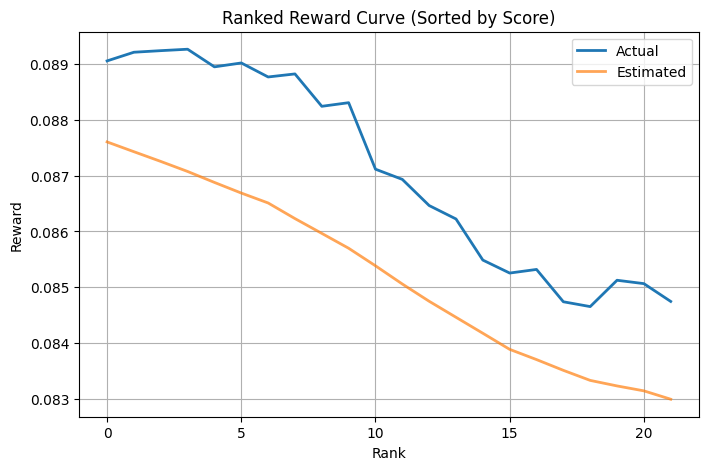

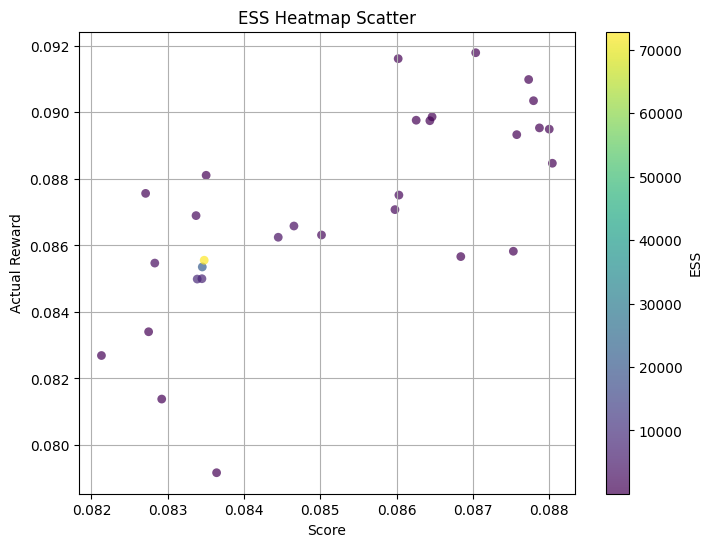

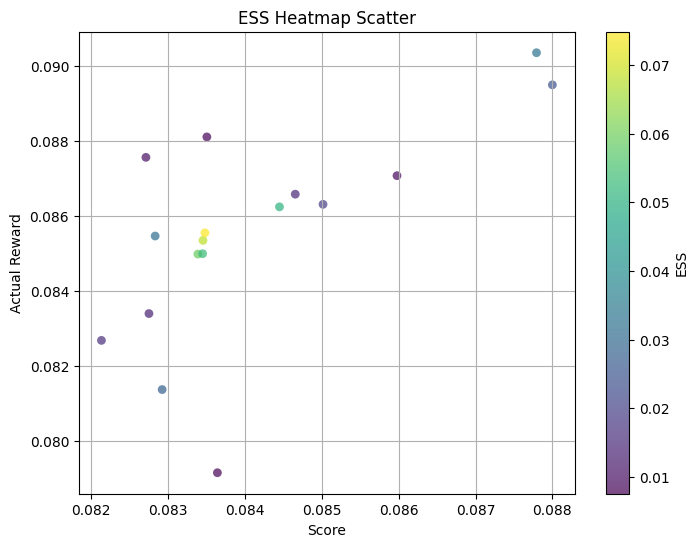

Correlation Metrics: {'pearson_score_actual': np.float64(0.703968461782406), 'spearman_score_actual': np.float64(0.7001112347052281), 'spearman_est_actual': np.float64(0.6912124582869855)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9946379247695246), 'ndcg_est_actual': np.float64(0.9946969734588152)}
Error Metrics: {'mean_error': np.float64(0.001465955798851192), 'mae': np.float64(0.0021004244661582414), 'rmse': np.float64(0.002544709261644625), 'std_error': np.float64(0.0020800285628121786), 'max_error': np.float64(0.005351235560154363), 'min_error': np.float64(-0.004540719096727541)}


In [ ]:
compute_statistics_and_plots(study_df8)

In [ ]:
# dataset_params = dict(
#                     n_actions= 500,
#                     n_users = 500,
#                     emb_dim = 16,
#                     # sigma = 0.1,
#                     eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
#                     ctr = 0.1
#                     )

train_dataset = generate_dataset(dataset_params, seed=50000)

Random Item CTR: 0.07308925129657047
Optimal greedy CTR: 0.0999990853390176
Second Best greedy CTR: 0.09942382949421147
Optimal Stochastic CTR: 0.0998654433282965
second Best Stochastic CTR: 0.08593335882324721
Our Initial CTR: 0.08596028929347854


In [ ]:
# Run the optimization
df9, study_df9 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=50000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df9.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{50000}.csv")
# Show the performance metrics
df9[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 100000 samples: 1.3119654655456543 seconds
[Regression] Baseline regression model fit time: 0.25s
Num samples is 50000
{'gini': np.float64(0.4124079474973358), 'ess': np.float64(26327.708667387877), 'max_wi': np.float64(41.113816910618816), 'min_wi': np.float64(0.012848733171872868)}
Eval time: 18.920714378356934 seconds
Evaluation total results time: 35.12 seconds

=== [Regression] Training size 250000, run 0 ===


[I 2026-01-04 11:36:45,355] A new study created in memory with name: no-name-32ecd6b6-d25d-4f66-bd4a-6098d19429a7


Simulation time for 300000 samples: 3.807964563369751 seconds


  0%|          | 0/30 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.09352565]


Best trial: 0. Best value: 0.0853091:   3%|▎         | 1/30 [00:34<16:48, 34.77s/it]

[I 2026-01-04 11:37:20,127] Trial 0 finished with value: 0.0853091228741955 and parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98}. Best is trial 0 with value: 0.0853091228741955.

[Regression] Optuna Trial 1
actual reward: [0.09291042]


Best trial: 1. Best value: 0.0857178:   7%|▋         | 2/30 [00:48<10:29, 22.48s/it]

[I 2026-01-04 11:37:33,996] Trial 1 finished with value: 0.08571778234922227 and parameters: {'lr': 0.008030090778924517, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9675257523608418}. Best is trial 1 with value: 0.08571778234922227.

[Regression] Optuna Trial 2
actual reward: [0.08750002]


Best trial: 1. Best value: 0.0857178:  10%|█         | 3/30 [00:59<07:46, 17.28s/it]

[I 2026-01-04 11:37:45,091] Trial 2 finished with value: 0.08407232389498699 and parameters: {'lr': 0.001208569554914711, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8561958442100326}. Best is trial 1 with value: 0.08571778234922227.

[Regression] Optuna Trial 3
actual reward: [0.08999004]


Best trial: 3. Best value: 0.08662:  13%|█▎        | 4/30 [01:10<06:25, 14.82s/it]  

[I 2026-01-04 11:37:56,149] Trial 3 finished with value: 0.08661998356458277 and parameters: {'lr': 0.030698619156523825, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8626725524234616}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 4
actual reward: [0.08818428]


Best trial: 3. Best value: 0.08662:  17%|█▋        | 5/30 [01:18<05:10, 12.41s/it]

[I 2026-01-04 11:38:04,285] Trial 4 finished with value: 0.08472188412713019 and parameters: {'lr': 0.0020355873289586235, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.9702251472835816}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 5
actual reward: [0.0799287]


Best trial: 3. Best value: 0.08662:  20%|██        | 6/30 [01:43<06:33, 16.41s/it]

[I 2026-01-04 11:38:28,462] Trial 5 finished with value: 0.08598004626763127 and parameters: {'lr': 0.07367951140276428, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9757983785234667}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 6
actual reward: [0.08633175]


Best trial: 3. Best value: 0.08662:  23%|██▎       | 7/30 [02:01<06:31, 17.01s/it]

[I 2026-01-04 11:38:46,707] Trial 6 finished with value: 0.08289172374768346 and parameters: {'lr': 0.00011620972232018312, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8920632770197184}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 7
actual reward: [0.08096384]


Best trial: 3. Best value: 0.08662:  27%|██▋       | 8/30 [02:32<07:50, 21.39s/it]

[I 2026-01-04 11:39:17,482] Trial 7 finished with value: 0.08576207994735538 and parameters: {'lr': 0.05454682265768181, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8418125284033187}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 8
actual reward: [0.08646173]


Best trial: 3. Best value: 0.08662:  30%|███       | 9/30 [02:49<07:03, 20.15s/it]

[I 2026-01-04 11:39:34,914] Trial 8 finished with value: 0.08299132636102216 and parameters: {'lr': 0.0001454147337353797, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9546128375896935}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 9
actual reward: [0.09057251]


Best trial: 3. Best value: 0.08662:  33%|███▎      | 10/30 [03:05<06:14, 18.74s/it]

[I 2026-01-04 11:39:50,498] Trial 9 finished with value: 0.08536334546371557 and parameters: {'lr': 0.003393958771018335, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8741873960304742}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 10
actual reward: [0.08778861]


Best trial: 3. Best value: 0.08662:  37%|███▋      | 11/30 [03:08<04:29, 14.18s/it]

[I 2026-01-04 11:39:54,320] Trial 10 finished with value: 0.085854135914001 and parameters: {'lr': 0.019611276825628726, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.8044045690354128}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 11
actual reward: [0.07749721]


Best trial: 3. Best value: 0.08662:  40%|████      | 12/30 [03:35<05:22, 17.94s/it]

[I 2026-01-04 11:40:20,858] Trial 11 finished with value: 0.0858518538315592 and parameters: {'lr': 0.09828884679150705, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.920846772373821}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 12
actual reward: [0.08909834]


Best trial: 3. Best value: 0.08662:  43%|████▎     | 13/30 [03:49<04:46, 16.83s/it]

[I 2026-01-04 11:40:35,126] Trial 12 finished with value: 0.0854844688055345 and parameters: {'lr': 0.03101083230939522, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9279700186849246}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 13
actual reward: [0.08979141]


Best trial: 3. Best value: 0.08662:  47%|████▋     | 14/30 [03:54<03:29, 13.10s/it]

[I 2026-01-04 11:40:39,602] Trial 13 finished with value: 0.08528549412809876 and parameters: {'lr': 0.013813728631218873, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.8326644964817571}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 14
actual reward: [0.08107857]


Best trial: 3. Best value: 0.08662:  50%|█████     | 15/30 [04:10<03:32, 14.19s/it]

[I 2026-01-04 11:40:56,326] Trial 14 finished with value: 0.08526274405957406 and parameters: {'lr': 0.08938423078933568, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.922736527215514}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 15
actual reward: [0.09081757]


Best trial: 3. Best value: 0.08662:  53%|█████▎    | 16/30 [04:17<02:46, 11.90s/it]

[I 2026-01-04 11:41:02,895] Trial 15 finished with value: 0.08567994201988018 and parameters: {'lr': 0.007759421380781638, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8904148578089418}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 16
actual reward: [0.08451811]


Best trial: 3. Best value: 0.08662:  57%|█████▋    | 17/30 [04:44<03:34, 16.50s/it]

[I 2026-01-04 11:41:30,108] Trial 16 finished with value: 0.08567555192465287 and parameters: {'lr': 0.031840435279432845, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9938910478144445}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 17
actual reward: [0.08732078]


Best trial: 3. Best value: 0.08662:  60%|██████    | 18/30 [04:58<03:09, 15.75s/it]

[I 2026-01-04 11:41:44,112] Trial 17 finished with value: 0.0838309441193317 and parameters: {'lr': 0.0004942717927577964, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9415485417996029}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 18
actual reward: [0.09018045]


Best trial: 3. Best value: 0.08662:  63%|██████▎   | 19/30 [05:05<02:22, 13.00s/it]

[I 2026-01-04 11:41:50,702] Trial 18 finished with value: 0.08557256605612684 and parameters: {'lr': 0.0072686052494137935, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8048584877194538}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 19
actual reward: [0.08792942]


Best trial: 3. Best value: 0.08662:  67%|██████▋   | 20/30 [05:24<02:28, 14.86s/it]

[I 2026-01-04 11:42:09,881] Trial 19 finished with value: 0.08536826025940183 and parameters: {'lr': 0.03965163524624606, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8654329753600896}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 20
actual reward: [0.09179934]


Best trial: 3. Best value: 0.08662:  70%|███████   | 21/30 [05:39<02:12, 14.76s/it]

[I 2026-01-04 11:42:24,416] Trial 20 finished with value: 0.08576938198176594 and parameters: {'lr': 0.017425974914894955, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9067903936495811}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 21
actual reward: [0.08751962]


Best trial: 3. Best value: 0.08662:  73%|███████▎  | 22/30 [05:42<01:31, 11.46s/it]

[I 2026-01-04 11:42:28,171] Trial 21 finished with value: 0.08547616152044027 and parameters: {'lr': 0.022286289592588174, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.8018545448152136}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 22
actual reward: [0.08318938]


Best trial: 3. Best value: 0.08662:  77%|███████▋  | 23/30 [05:48<01:07,  9.65s/it]

[I 2026-01-04 11:42:33,606] Trial 22 finished with value: 0.08506670626088014 and parameters: {'lr': 0.0620908751559975, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.8189585105763432}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 23
actual reward: [0.09032627]


Best trial: 3. Best value: 0.08662:  80%|████████  | 24/30 [05:56<00:56,  9.36s/it]

[I 2026-01-04 11:42:42,289] Trial 23 finished with value: 0.08616408539777728 and parameters: {'lr': 0.015158046645940193, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8478042732378933}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 24
actual reward: [0.09241816]


Best trial: 3. Best value: 0.08662:  83%|████████▎ | 25/30 [06:05<00:45,  9.18s/it]

[I 2026-01-04 11:42:51,055] Trial 24 finished with value: 0.08596735583886567 and parameters: {'lr': 0.010645952291062752, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8482275863572428}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 25
actual reward: [0.09030223]


Best trial: 3. Best value: 0.08662:  87%|████████▋ | 26/30 [06:12<00:34,  8.53s/it]

[I 2026-01-04 11:42:58,055] Trial 25 finished with value: 0.08545493087584399 and parameters: {'lr': 0.005097641800283234, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.8771515851754794}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 26
actual reward: [0.08657912]


Best trial: 3. Best value: 0.08662:  90%|█████████ | 27/30 [06:22<00:26,  8.86s/it]

[I 2026-01-04 11:43:07,692] Trial 26 finished with value: 0.08640859142685307 and parameters: {'lr': 0.04979273515824271, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8233661115715334}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 27
actual reward: [0.08999032]


Best trial: 3. Best value: 0.08662:  93%|█████████▎| 28/30 [06:32<00:18,  9.18s/it]

[I 2026-01-04 11:43:17,604] Trial 27 finished with value: 0.08611818377266463 and parameters: {'lr': 0.04512639757956968, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8264361541184909}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 28
actual reward: [0.08813243]


Best trial: 3. Best value: 0.08662:  97%|█████████▋| 29/30 [06:43<00:09,  9.78s/it]

[I 2026-01-04 11:43:28,782] Trial 28 finished with value: 0.08625629074254319 and parameters: {'lr': 0.03158753423920045, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8400091945951765}. Best is trial 3 with value: 0.08661998356458277.

[Regression] Optuna Trial 29
actual reward: [0.09069578]


Best trial: 3. Best value: 0.08662: 100%|██████████| 30/30 [06:54<00:00, 13.82s/it]


[I 2026-01-04 11:43:39,830] Trial 29 finished with value: 0.0862761698541707 and parameters: {'lr': 0.02396887779664143, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8180505061353333}. Best is trial 3 with value: 0.08661998356458277.
Num samples is 50000
{'gini': np.float64(0.9977814608605318), 'ess': np.float64(85.96808714609267), 'max_wi': np.float64(1921.1006149850002), 'min_wi': np.float64(9.404824072516591e-24)}
Eval time: 17.671361684799194 seconds
Evaluation total results time: 34.23 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
0,0.08596029,0.08618000,0.08710767,0.08710767,0.08613821,0.08613821,0.75394551,0.00000000,0.77463545,0.00000000
250000,0.09091867,0.05350842,0.08645057,0.08645057,0.04865297,0.05355782,0.94760972,0.55941053,1.17362708,0.76737838


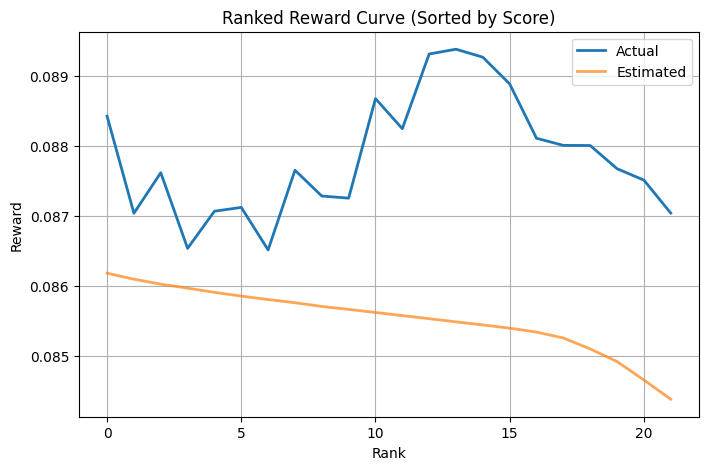

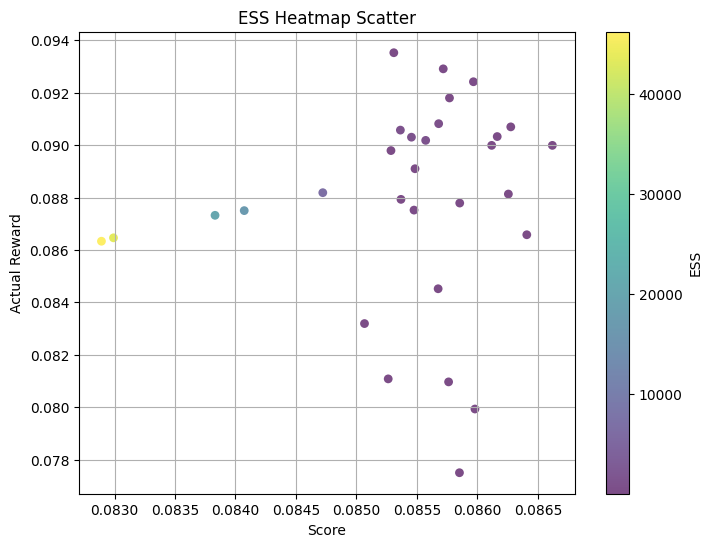

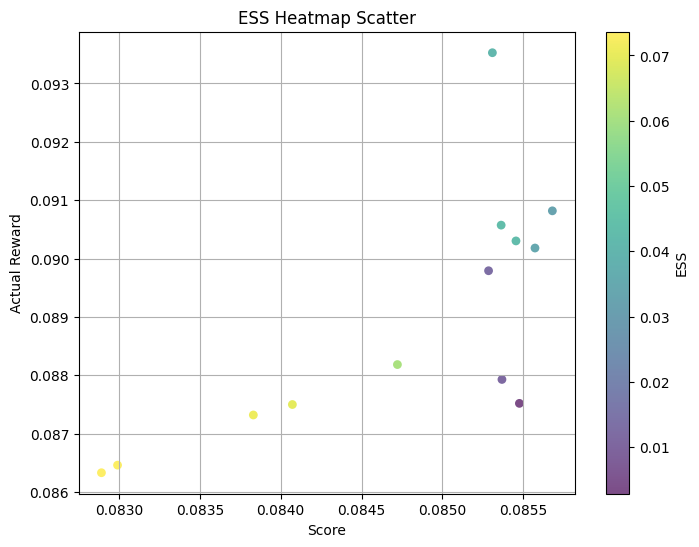

Correlation Metrics: {'pearson_score_actual': np.float64(0.11363860042237824), 'spearman_score_actual': np.float64(0.22180200222469412), 'spearman_est_actual': np.float64(0.4273637374860957)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9880337227118016), 'ndcg_est_actual': np.float64(0.9901907915560961)}
Error Metrics: {'mean_error': np.float64(0.0019224200335612887), 'mae': np.float64(0.00371770261865731), 'rmse': np.float64(0.004227800868536615), 'std_error': np.float64(0.0037654483662056997), 'max_error': np.float64(0.007824652707246874), 'min_error': np.float64(-0.008419363373906585)}


In [ ]:
compute_statistics_and_plots(study_df9)

In [ ]:
all_dfs = pd.concat([study_df, study_df5, study_df6, study_df7, study_df8, study_df9], ignore_index=True)
all_dfs = all_dfs[all_dfs['value'] > 0]
# all_dfs['user_attrs_actual_reward'] = all_dfs['user_attrs_actual_reward'].apply(lambda x: x[0])

In [ ]:
all_dfs.head(5)

,value,user_attrs_actual_reward,user_attrs_q_error,user_attrs_r_hat,user_attrs_ess,user_attrs_scores_dict,user_attrs_all_values
0,0.08778785,0.09011210,0.00014227,0.08806669,413.95921676,"{'dr_naive_mean': 0.08806669102680653, 'dr_nai...","[0.08806669102680653, 0.08806266604342869, 0.0..."
1,0.08625738,0.08681637,0.00014114,0.08653400,317.42173029,"{'dr_naive_mean': 0.08653400137662663, 'dr_nai...","[0.08653400137662663, 0.08652410180235526, 0.0..."
2,0.08461695,0.07246351,0.00004189,0.08469907,354.36741834,"{'dr_naive_mean': 0.08469906706969256, 'dr_nai...","[0.08469906706969256, 0.08468245075554404, 0.0..."
3,0.08428654,0.08029869,0.00006783,0.08441948,669.96306994,"{'dr_naive_mean': 0.08441948274171246, 'dr_nai...","[0.08441948274171246, 0.08441964992054762, 0.0..."
4,0.08353456,0.08030789,0.00022391,0.08397341,"5,652.11056819","{'dr_naive_mean': 0.08397341022882376, 'dr_nai...","[0.08397341022882376, 0.0839641426719494, 0.07..."


In [ ]:
from plots_and_stats import compute_statistics_and_plots
import pandas as pd

In [ ]:
all_dfs.to_csv(f"trial_dfs/regression_model_opl_study_results_all_seeds_{n_trials_for_optuna}.csv", index=False)

In [ ]:
compute_statistics_and_plots(all_dfs)

Random Item CTR: 0.07299616499379533
Optimal greedy CTR: 0.09999912765877851
Second Best greedy CTR: 0.09924234208905701
Optimal Stochastic CTR: 0.09986822971033672
second Best Stochastic CTR: 0.08585992378345159
Our Initial CTR: 0.08589106637164244
Simulation time for 200000 samples: 3.358289957046509 seconds
[Regression] Baseline regression model fit time: 0.23s
Num samples is 100000
{'gini': np.float64(0.4107275166930773), 'ess': np.float64(53190.95544516733), 'max_wi': np.float64(42.59412909696399), 'min_wi': np.float64(0.006231567428004751)}
Eval time: 43.348756074905396 seconds
Evaluation total results time: 78.56 seconds

=== [Regression] Training size 10000, run 0 ===


[I 2026-01-05 22:19:19,098] A new study created in memory with name: no-name-817b5104-28b1-4886-a254-3648a7a22abe


Simulation time for 110000 samples: 1.593470811843872 seconds


  0%|          | 0/30 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.08664379]


Best trial: 0. Best value: 0.0849054:   3%|▎         | 1/30 [00:04<02:11,  4.52s/it]

[I 2026-01-05 22:19:23,616] Trial 0 finished with value: 0.08490540881786827 and parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98}. Best is trial 0 with value: 0.08490540881786827.

[Regression] Optuna Trial 1
actual reward: [0.08589382]


Best trial: 0. Best value: 0.0849054:   7%|▋         | 2/30 [00:07<01:38,  3.53s/it]

[I 2026-01-05 22:19:26,461] Trial 1 finished with value: 0.08388593300191702 and parameters: {'lr': 0.0002203251544842426, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9582438213412198}. Best is trial 0 with value: 0.08490540881786827.

[Regression] Optuna Trial 2
actual reward: [0.08724805]


Best trial: 0. Best value: 0.0849054:  10%|█         | 3/30 [00:10<01:27,  3.24s/it]

[I 2026-01-05 22:19:29,348] Trial 2 finished with value: 0.08276561920939386 and parameters: {'lr': 0.07547549223775592, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9967824584716942}. Best is trial 0 with value: 0.08490540881786827.

[Regression] Optuna Trial 3
actual reward: [0.08735094]


Best trial: 3. Best value: 0.0864224:  13%|█▎        | 4/30 [00:14<01:31,  3.51s/it]

[I 2026-01-05 22:19:33,279] Trial 3 finished with value: 0.08642239182418719 and parameters: {'lr': 0.0077268724094555425, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9635307773630561}. Best is trial 3 with value: 0.08642239182418719.

[Regression] Optuna Trial 4
actual reward: [0.08697981]


Best trial: 3. Best value: 0.0864224:  17%|█▋        | 5/30 [00:17<01:24,  3.37s/it]

[I 2026-01-05 22:19:36,411] Trial 4 finished with value: 0.08497513515781993 and parameters: {'lr': 0.01916940633080906, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9348874469119762}. Best is trial 3 with value: 0.08642239182418719.

[Regression] Optuna Trial 5
actual reward: [0.08589796]


Best trial: 3. Best value: 0.0864224:  20%|██        | 6/30 [00:20<01:17,  3.24s/it]

[I 2026-01-05 22:19:39,380] Trial 5 finished with value: 0.08389613970410181 and parameters: {'lr': 0.0001738528139460616, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9647729562963606}. Best is trial 3 with value: 0.08642239182418719.

[Regression] Optuna Trial 6
actual reward: [0.08589715]


Best trial: 3. Best value: 0.0864224:  23%|██▎       | 7/30 [00:22<01:10,  3.06s/it]

[I 2026-01-05 22:19:42,082] Trial 6 finished with value: 0.08389803040474711 and parameters: {'lr': 0.0006929002136988477, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9500698909810391}. Best is trial 3 with value: 0.08642239182418719.

[Regression] Optuna Trial 7
actual reward: [0.08594929]


Best trial: 3. Best value: 0.0864224:  27%|██▋       | 8/30 [00:25<01:04,  2.93s/it]

[I 2026-01-05 22:19:44,720] Trial 7 finished with value: 0.08409220489193595 and parameters: {'lr': 0.00626695572821813, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.8001768367276519}. Best is trial 3 with value: 0.08642239182418719.

[Regression] Optuna Trial 8
actual reward: [0.08709545]


Best trial: 3. Best value: 0.0864224:  30%|███       | 9/30 [00:29<01:05,  3.13s/it]

[I 2026-01-05 22:19:48,304] Trial 8 finished with value: 0.08505687842380162 and parameters: {'lr': 0.007959260920486646, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8480884787949936}. Best is trial 3 with value: 0.08642239182418719.

[Regression] Optuna Trial 9
actual reward: [0.0859159]


Best trial: 3. Best value: 0.0864224:  33%|███▎      | 10/30 [00:32<01:04,  3.20s/it]

[I 2026-01-05 22:19:51,656] Trial 9 finished with value: 0.08393869739448209 and parameters: {'lr': 0.0003378868530062478, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8927356280902881}. Best is trial 3 with value: 0.08642239182418719.

[Regression] Optuna Trial 10
actual reward: [0.0861012]


Best trial: 3. Best value: 0.0864224:  37%|███▋      | 11/30 [00:36<01:04,  3.40s/it]

[I 2026-01-05 22:19:55,505] Trial 10 finished with value: 0.08442566165088601 and parameters: {'lr': 0.0016181520568265134, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9095671098854157}. Best is trial 3 with value: 0.08642239182418719.

[Regression] Optuna Trial 11
actual reward: [0.08826118]


Best trial: 11. Best value: 0.089664:  40%|████      | 12/30 [00:40<01:03,  3.52s/it]

[I 2026-01-05 22:19:59,288] Trial 11 finished with value: 0.08966399330457148 and parameters: {'lr': 0.014663685937281278, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8466094512985968}. Best is trial 11 with value: 0.08966399330457148.

[Regression] Optuna Trial 12
actual reward: [0.08738493]


Best trial: 12. Best value: 0.0896955:  43%|████▎     | 13/30 [00:44<01:02,  3.67s/it]

[I 2026-01-05 22:20:03,309] Trial 12 finished with value: 0.08969546556134565 and parameters: {'lr': 0.030521127997310205, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8600557592918286}. Best is trial 12 with value: 0.08969546556134565.

[Regression] Optuna Trial 13
actual reward: [0.08606065]


Best trial: 12. Best value: 0.0896955:  47%|████▋     | 14/30 [00:47<00:57,  3.60s/it]

[I 2026-01-05 22:20:06,744] Trial 13 finished with value: 0.08948222539785215 and parameters: {'lr': 0.056643890934304636, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8490139020029353}. Best is trial 12 with value: 0.08969546556134565.

[Regression] Optuna Trial 14
actual reward: [0.08726477]


Best trial: 12. Best value: 0.0896955:  50%|█████     | 15/30 [00:51<00:54,  3.62s/it]

[I 2026-01-05 22:20:10,406] Trial 14 finished with value: 0.08613518859146152 and parameters: {'lr': 0.02720618214500791, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.8538611894136072}. Best is trial 12 with value: 0.08969546556134565.

[Regression] Optuna Trial 15
actual reward: [0.0877193]


Best trial: 12. Best value: 0.0896955:  53%|█████▎    | 16/30 [00:55<00:52,  3.77s/it]

[I 2026-01-05 22:20:14,526] Trial 15 finished with value: 0.08627101813122569 and parameters: {'lr': 0.018935950617568108, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8101794972952091}. Best is trial 12 with value: 0.08969546556134565.

[Regression] Optuna Trial 16
actual reward: [0.08834781]


Best trial: 12. Best value: 0.0896955:  57%|█████▋    | 17/30 [01:00<00:53,  4.08s/it]

[I 2026-01-05 22:20:19,336] Trial 16 finished with value: 0.08948388487780713 and parameters: {'lr': 0.0346609325654733, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8815142105965106}. Best is trial 12 with value: 0.08969546556134565.

[Regression] Optuna Trial 17
actual reward: [0.08769425]


Best trial: 12. Best value: 0.0896955:  60%|██████    | 18/30 [01:03<00:47,  3.96s/it]

[I 2026-01-05 22:20:23,022] Trial 17 finished with value: 0.08625220056295006 and parameters: {'lr': 0.01202080037411634, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.827648532492246}. Best is trial 12 with value: 0.08969546556134565.

[Regression] Optuna Trial 18
actual reward: [0.08196959]


Best trial: 12. Best value: 0.0896955:  63%|██████▎   | 19/30 [01:07<00:41,  3.77s/it]

[I 2026-01-05 22:20:26,343] Trial 18 finished with value: 0.07357299207628791 and parameters: {'lr': 0.09073497292320892, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.872826201042234}. Best is trial 12 with value: 0.08969546556134565.

[Regression] Optuna Trial 19
actual reward: [0.0865045]


Best trial: 12. Best value: 0.0896955:  67%|██████▋   | 20/30 [01:11<00:37,  3.78s/it]

[I 2026-01-05 22:20:30,159] Trial 19 finished with value: 0.08467966694018182 and parameters: {'lr': 0.003860351694943941, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9103328179913934}. Best is trial 12 with value: 0.08969546556134565.

[Regression] Optuna Trial 20
actual reward: [0.08938616]


Best trial: 12. Best value: 0.0896955:  70%|███████   | 21/30 [01:14<00:34,  3.81s/it]

[I 2026-01-05 22:20:34,019] Trial 20 finished with value: 0.08850253390258536 and parameters: {'lr': 0.04215070381165619, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8306313134194384}. Best is trial 12 with value: 0.08969546556134565.

[Regression] Optuna Trial 21
actual reward: [0.08795827]


Best trial: 12. Best value: 0.0896955:  73%|███████▎  | 22/30 [01:19<00:32,  4.03s/it]

[I 2026-01-05 22:20:38,562] Trial 21 finished with value: 0.08910513503536345 and parameters: {'lr': 0.034255524190342106, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8820848522926303}. Best is trial 12 with value: 0.08969546556134565.

[Regression] Optuna Trial 22
actual reward: [0.08790581]


Best trial: 12. Best value: 0.0896955:  77%|███████▋  | 23/30 [01:24<00:29,  4.20s/it]

[I 2026-01-05 22:20:43,156] Trial 22 finished with value: 0.0846454407811991 and parameters: {'lr': 0.017990123380381685, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8675130572833186}. Best is trial 12 with value: 0.08969546556134565.

[Regression] Optuna Trial 23
actual reward: [0.0881528]


Best trial: 12. Best value: 0.0896955:  80%|████████  | 24/30 [01:28<00:25,  4.29s/it]

[I 2026-01-05 22:20:47,655] Trial 23 finished with value: 0.08678535287705809 and parameters: {'lr': 0.036165580837232564, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8317446213383313}. Best is trial 12 with value: 0.08969546556134565.

[Regression] Optuna Trial 24
actual reward: [0.08760953]


Best trial: 12. Best value: 0.0896955:  83%|████████▎ | 25/30 [01:32<00:20,  4.15s/it]

[I 2026-01-05 22:20:51,492] Trial 24 finished with value: 0.08619281040911501 and parameters: {'lr': 0.01069194151919041, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8935983269777508}. Best is trial 12 with value: 0.08969546556134565.

[Regression] Optuna Trial 25
actual reward: [0.08906767]


Best trial: 12. Best value: 0.0896955:  87%|████████▋ | 26/30 [01:36<00:16,  4.23s/it]

[I 2026-01-05 22:20:55,913] Trial 25 finished with value: 0.0853817369269349 and parameters: {'lr': 0.05545946972687893, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8640123396426368}. Best is trial 12 with value: 0.08969546556134565.

[Regression] Optuna Trial 26
actual reward: [0.08648403]


Best trial: 12. Best value: 0.0896955:  90%|█████████ | 27/30 [01:40<00:11,  3.99s/it]

[I 2026-01-05 22:20:59,346] Trial 26 finished with value: 0.0847580845093579 and parameters: {'lr': 0.004559462297282179, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9302212124247382}. Best is trial 12 with value: 0.08969546556134565.

[Regression] Optuna Trial 27
actual reward: [0.08698691]


Best trial: 12. Best value: 0.0896955:  93%|█████████▎| 28/30 [01:43<00:07,  3.77s/it]

[I 2026-01-05 22:21:02,612] Trial 27 finished with value: 0.08457715969077201 and parameters: {'lr': 0.013298626494085756, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8393691195024681}. Best is trial 12 with value: 0.08969546556134565.

[Regression] Optuna Trial 28
actual reward: [0.08600155]


Best trial: 12. Best value: 0.0896955:  97%|█████████▋| 29/30 [01:46<00:03,  3.61s/it]

[I 2026-01-05 22:21:05,833] Trial 28 finished with value: 0.08421426814922471 and parameters: {'lr': 0.0020429941943171394, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8171821480708418}. Best is trial 12 with value: 0.08969546556134565.

[Regression] Optuna Trial 29
actual reward: [0.08858201]


Best trial: 12. Best value: 0.0896955: 100%|██████████| 30/30 [01:50<00:00,  3.70s/it]


[I 2026-01-05 22:21:10,007] Trial 29 finished with value: 0.08751741094820671 and parameters: {'lr': 0.022880317296732542, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8831667492357124}. Best is trial 12 with value: 0.08969546556134565.
Num samples is 100000
{'gini': np.float64(0.9375639432658759), 'ess': np.float64(614.2693704556863), 'max_wi': np.float64(1164.287183444733), 'min_wi': np.float64(7.651098775525769e-07)}
Eval time: 38.9272301197052 seconds
Evaluation total results time: 73.51 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_diff_to_real
0,0.08589107,0.08703000,0.08800404,0.08800404,0.08704259,0.08704259,0.76670009,0.00000000,0.83964109,0.83964109
10000,0.08811816,0.08586219,0.08087952,0.08087952,0.08603519,0.08610267,0.86575579,0.30261570,0.91547839,0.91547839


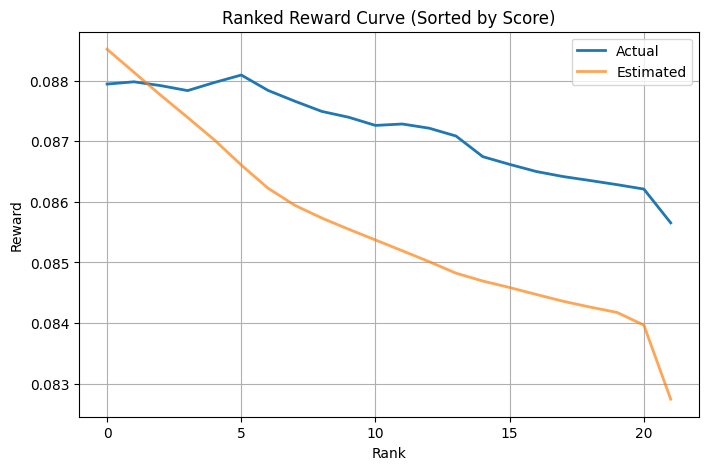

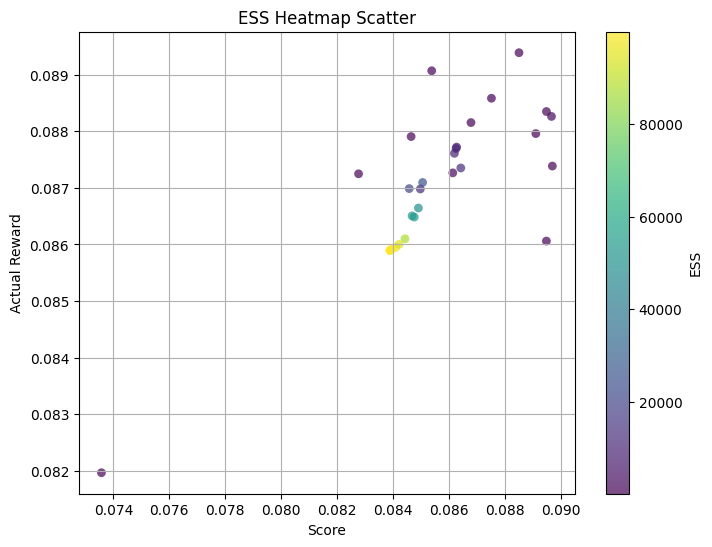

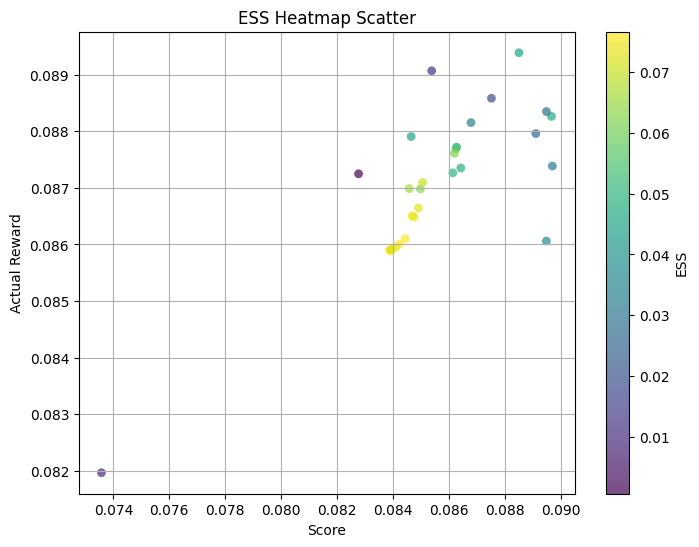

Correlation Metrics: {'pearson_score_actual': np.float64(0.7904739905643916), 'spearman_score_actual': np.float64(0.7579532814238041), 'spearman_est_actual': np.float64(0.6395995550611792)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9971563247305014), 'ndcg_est_actual': np.float64(0.9972090721593131)}
Error Metrics: {'mean_error': np.float64(0.0007323067173985791), 'mae': np.float64(0.001498804301753714), 'rmse': np.float64(0.0022016293119540425), 'std_error': np.float64(0.0020762703337735547), 'max_error': np.float64(0.008232950321632987), 'min_error': np.float64(-0.00380915399468644)}
Random Item CTR: 0.07308925129657047
Optimal greedy CTR: 0.0999990853390176
Second Best greedy CTR: 0.09942382949421147
Optimal Stochastic CTR: 0.0998654433282965
second Best Stochastic CTR: 0.08593335882324721
Our Initial CTR: 0.08596028929347854
Simulation time for 200000 samples: 2.930402994155884 seconds
[Regression] Baseline regression model fit time: 0.26s
Num samples is 100000
{'gini': np.f

[I 2026-01-05 22:23:47,662] A new study created in memory with name: no-name-25fa10e6-85e1-4323-b2f9-7297ddf75d68


Simulation time for 150000 samples: 2.0894246101379395 seconds


  0%|          | 0/30 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.08918768]


Best trial: 0. Best value: 0.0849929:   3%|▎         | 1/30 [00:10<05:11, 10.74s/it]

[I 2026-01-05 22:23:58,401] Trial 0 finished with value: 0.08499293421218651 and parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98}. Best is trial 0 with value: 0.08499293421218651.

[Regression] Optuna Trial 1
actual reward: [0.08618552]


Best trial: 1. Best value: 0.085511:   7%|▋         | 2/30 [00:16<03:39,  7.85s/it] 

[I 2026-01-05 22:24:04,224] Trial 1 finished with value: 0.08551097230471141 and parameters: {'lr': 0.00040153357680784994, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9944554794877984}. Best is trial 1 with value: 0.08551097230471141.

[Regression] Optuna Trial 2
actual reward: [0.08600718]


Best trial: 2. Best value: 0.085764:  10%|█         | 3/30 [00:23<03:14,  7.21s/it]

[I 2026-01-05 22:24:10,683] Trial 2 finished with value: 0.08576397561956338 and parameters: {'lr': 0.00010702518263919282, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8572999436778996}. Best is trial 2 with value: 0.08576397561956338.

[Regression] Optuna Trial 3
actual reward: [0.08604292]


Best trial: 2. Best value: 0.085764:  13%|█▎        | 4/30 [00:30<03:09,  7.31s/it]

[I 2026-01-05 22:24:18,130] Trial 3 finished with value: 0.08571435034874533 and parameters: {'lr': 0.00016338499427203372, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8351502408371584}. Best is trial 2 with value: 0.08576397561956338.

[Regression] Optuna Trial 4
actual reward: [0.08624203]


Best trial: 2. Best value: 0.085764:  17%|█▋        | 5/30 [00:34<02:32,  6.10s/it]

[I 2026-01-05 22:24:22,087] Trial 4 finished with value: 0.0854282246319485 and parameters: {'lr': 0.001507471147483828, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.8516175130017676}. Best is trial 2 with value: 0.08576397561956338.

[Regression] Optuna Trial 5
actual reward: [0.08968228]


Best trial: 5. Best value: 0.0894099:  20%|██        | 6/30 [00:39<02:22,  5.92s/it]

[I 2026-01-05 22:24:27,655] Trial 5 finished with value: 0.08940987239886188 and parameters: {'lr': 0.019184920673820757, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9507662902305895}. Best is trial 5 with value: 0.08940987239886188.

[Regression] Optuna Trial 6
actual reward: [0.08890613]


Best trial: 5. Best value: 0.0894099:  23%|██▎       | 7/30 [00:44<02:02,  5.31s/it]

[I 2026-01-05 22:24:31,727] Trial 6 finished with value: 0.08259906438919191 and parameters: {'lr': 0.019878230756564093, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8529570143930367}. Best is trial 5 with value: 0.08940987239886188.

[Regression] Optuna Trial 7
actual reward: [0.08572641]


Best trial: 5. Best value: 0.0894099:  27%|██▋       | 8/30 [00:54<02:30,  6.82s/it]

[I 2026-01-05 22:24:41,780] Trial 7 finished with value: 0.08461293694777973 and parameters: {'lr': 0.05971839658480941, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8905602899102093}. Best is trial 5 with value: 0.08940987239886188.

[Regression] Optuna Trial 8
actual reward: [0.08636899]


Best trial: 5. Best value: 0.0894099:  30%|███       | 9/30 [00:58<02:04,  5.91s/it]

[I 2026-01-05 22:24:45,691] Trial 8 finished with value: 0.08528605838339394 and parameters: {'lr': 0.002020859241353447, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.8881453199044949}. Best is trial 5 with value: 0.08940987239886188.

[Regression] Optuna Trial 9
actual reward: [0.08623196]


Best trial: 5. Best value: 0.0894099:  33%|███▎      | 10/30 [01:01<01:42,  5.13s/it]

[I 2026-01-05 22:24:49,076] Trial 9 finished with value: 0.08542964415535863 and parameters: {'lr': 0.002530651197130953, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.8594981384301921}. Best is trial 5 with value: 0.08940987239886188.

[Regression] Optuna Trial 10
actual reward: [0.08741503]


Best trial: 5. Best value: 0.0894099:  37%|███▋      | 11/30 [01:04<01:27,  4.59s/it]

[I 2026-01-05 22:24:52,437] Trial 10 finished with value: 0.08331933357579488 and parameters: {'lr': 0.01443392722850995, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.9465695051199026}. Best is trial 5 with value: 0.08940987239886188.

[Regression] Optuna Trial 11
actual reward: [0.08985474]


Best trial: 11. Best value: 0.0898476:  40%|████      | 12/30 [01:13<01:42,  5.70s/it]

[I 2026-01-05 22:25:00,665] Trial 11 finished with value: 0.08984761863825894 and parameters: {'lr': 0.01194933736306372, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9374695149137839}. Best is trial 11 with value: 0.08984761863825894.

[Regression] Optuna Trial 12
actual reward: [0.09055175]


Best trial: 12. Best value: 0.0912951:  43%|████▎     | 13/30 [01:24<02:07,  7.52s/it]

[I 2026-01-05 22:25:12,393] Trial 12 finished with value: 0.09129510920511491 and parameters: {'lr': 0.01120719193076223, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.935693139754083}. Best is trial 12 with value: 0.09129510920511491.

[Regression] Optuna Trial 13


Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0><function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0><function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0><function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>



Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663,

actual reward: [0.08850074]


Best trial: 12. Best value: 0.0912951:  47%|████▋     | 14/30 [01:31<01:57,  7.36s/it]

[I 2026-01-05 22:25:19,380] Trial 13 finished with value: 0.08331380978083713 and parameters: {'lr': 0.006473147481416174, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9288407012128469}. Best is trial 12 with value: 0.09129510920511491.

[Regression] Optuna Trial 14
actual reward: [0.08490898]


Best trial: 12. Best value: 0.0912951:  50%|█████     | 15/30 [01:44<02:12,  8.86s/it]

[I 2026-01-05 22:25:31,712] Trial 14 finished with value: 0.08424776840435404 and parameters: {'lr': 0.09378913433737626, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8013392838583487}. Best is trial 12 with value: 0.09129510920511491.

[Regression] Optuna Trial 15
actual reward: [0.08986057]


Best trial: 15. Best value: 0.0928805:  53%|█████▎    | 16/30 [01:53<02:06,  9.00s/it]

[I 2026-01-05 22:25:41,043] Trial 15 finished with value: 0.09288050980146074 and parameters: {'lr': 0.010299770214216037, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9217633795438341}. Best is trial 15 with value: 0.09288050980146074.

[Regression] Optuna Trial 16
actual reward: [0.0884458]


Best trial: 15. Best value: 0.0928805:  57%|█████▋    | 17/30 [02:02<01:58,  9.11s/it]

[I 2026-01-05 22:25:50,411] Trial 16 finished with value: 0.08576203693530463 and parameters: {'lr': 0.04125647508139294, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9150549868371272}. Best is trial 15 with value: 0.09288050980146074.

[Regression] Optuna Trial 17


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0><function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>
Exception ignored in: 
Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

Traceback (most recent call last):
        self._shutdown_workers()  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()

      File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/roee/Documents/code/OPC/.ve

actual reward: [0.0880827]


Best trial: 15. Best value: 0.0928805:  60%|██████    | 18/30 [02:09<01:39,  8.29s/it]

[I 2026-01-05 22:25:56,790] Trial 17 finished with value: 0.08366996509212324 and parameters: {'lr': 0.004939799494151225, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9682354269561548}. Best is trial 15 with value: 0.09288050980146074.

[Regression] Optuna Trial 18
actual reward: [0.08626643]


Best trial: 15. Best value: 0.0928805:  63%|██████▎   | 19/30 [02:15<01:24,  7.65s/it]

[I 2026-01-05 22:26:02,957] Trial 18 finished with value: 0.0854244650855729 and parameters: {'lr': 0.0005834681062552856, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9100651666480367}. Best is trial 15 with value: 0.09288050980146074.

[Regression] Optuna Trial 19
actual reward: [0.09070917]


Best trial: 15. Best value: 0.0928805:  67%|██████▋   | 20/30 [02:26<01:26,  8.66s/it]

[I 2026-01-05 22:26:13,956] Trial 19 finished with value: 0.09174699333749325 and parameters: {'lr': 0.006545140357417112, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9652921600190406}. Best is trial 15 with value: 0.09288050980146074.

[Regression] Optuna Trial 20
actual reward: [0.09066582]


Best trial: 15. Best value: 0.0928805:  70%|███████   | 21/30 [02:35<01:19,  8.85s/it]

[I 2026-01-05 22:26:23,253] Trial 20 finished with value: 0.08920524456752622 and parameters: {'lr': 0.0058278877451931, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9655929466003963}. Best is trial 15 with value: 0.09288050980146074.

[Regression] Optuna Trial 21
actual reward: [0.09078572]


Best trial: 15. Best value: 0.0928805:  73%|███████▎  | 22/30 [02:46<01:16,  9.55s/it]

[I 2026-01-05 22:26:34,435] Trial 21 finished with value: 0.08751500443492383 and parameters: {'lr': 0.033868499287096336, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.930799553051516}. Best is trial 15 with value: 0.09288050980146074.

[Regression] Optuna Trial 22
actual reward: [0.09207526]


Best trial: 15. Best value: 0.0928805:  77%|███████▋  | 23/30 [02:57<01:09,  9.98s/it]

[I 2026-01-05 22:26:45,405] Trial 22 finished with value: 0.09125088602443206 and parameters: {'lr': 0.008607280069879444, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.999922551708742}. Best is trial 15 with value: 0.09288050980146074.

[Regression] Optuna Trial 23
actual reward: [0.08774745]


Best trial: 15. Best value: 0.0928805:  80%|████████  | 24/30 [03:10<01:04, 10.72s/it]

[I 2026-01-05 22:26:57,877] Trial 23 finished with value: 0.0845404257628411 and parameters: {'lr': 0.0011495923246939905, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9543162195759882}. Best is trial 15 with value: 0.09288050980146074.

[Regression] Optuna Trial 24
actual reward: [0.08965636]


Best trial: 15. Best value: 0.0928805:  83%|████████▎ | 25/30 [03:19<00:52, 10.42s/it]

[I 2026-01-05 22:27:07,591] Trial 24 finished with value: 0.08623622381350447 and parameters: {'lr': 0.004430183995255882, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9134947413947778}. Best is trial 15 with value: 0.09288050980146074.

[Regression] Optuna Trial 25
actual reward: [0.09023457]


Best trial: 15. Best value: 0.0928805:  87%|████████▋ | 26/30 [03:31<00:43, 10.80s/it]

[I 2026-01-05 22:27:19,280] Trial 25 finished with value: 0.0898261285414301 and parameters: {'lr': 0.026485463675643757, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8792638742246074}. Best is trial 15 with value: 0.09288050980146074.

[Regression] Optuna Trial 26
actual reward: [0.0903046]


Best trial: 15. Best value: 0.0928805:  90%|█████████ | 27/30 [03:37<00:28,  9.38s/it]

[I 2026-01-05 22:27:25,328] Trial 26 finished with value: 0.08435918413591015 and parameters: {'lr': 0.008858617457543825, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9783533029335408}. Best is trial 15 with value: 0.09288050980146074.

[Regression] Optuna Trial 27
actual reward: [0.08901191]


Best trial: 15. Best value: 0.0928805:  93%|█████████▎| 28/30 [03:46<00:18,  9.18s/it]

[I 2026-01-05 22:27:34,035] Trial 27 finished with value: 0.08433197695785069 and parameters: {'lr': 0.0037012079118443502, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9205157067908846}. Best is trial 15 with value: 0.09288050980146074.

[Regression] Optuna Trial 28
actual reward: [0.0892279]


Best trial: 15. Best value: 0.0928805:  97%|█████████▋| 29/30 [03:52<00:08,  8.21s/it]

[I 2026-01-05 22:27:39,977] Trial 28 finished with value: 0.08328934657539135 and parameters: {'lr': 0.011001598359282997, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8995425364078189}. Best is trial 15 with value: 0.09288050980146074.

[Regression] Optuna Trial 29
actual reward: [0.08969485]


Best trial: 15. Best value: 0.0928805: 100%|██████████| 30/30 [04:02<00:00,  8.09s/it]


[I 2026-01-05 22:27:50,383] Trial 29 finished with value: 0.08605855086649235 and parameters: {'lr': 0.003099782685510391, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9794504930358645}. Best is trial 15 with value: 0.09288050980146074.
Num samples is 100000
{'gini': np.float64(0.9655241922712922), 'ess': np.float64(596.2370964164922), 'max_wi': np.float64(1578.6602330243168), 'min_wi': np.float64(7.874733345932134e-08)}
Eval time: 37.6402862071991 seconds
Evaluation total results time: 71.41 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_diff_to_real
0,0.08596029,0.08750000,0.08802045,0.08802045,0.08750228,0.08750228,0.75394551,0.00000000,0.77463545,0.77463545
50000,0.08991524,0.08118499,0.08284867,0.08284867,0.08122506,0.08118899,0.86481907,0.39472152,0.92099960,0.92099960


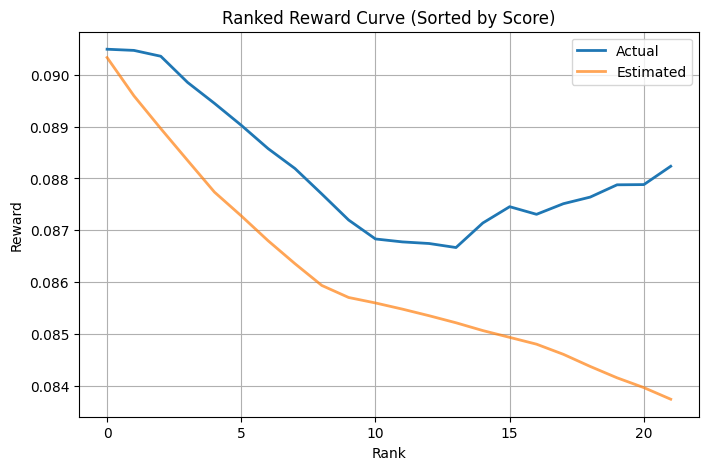

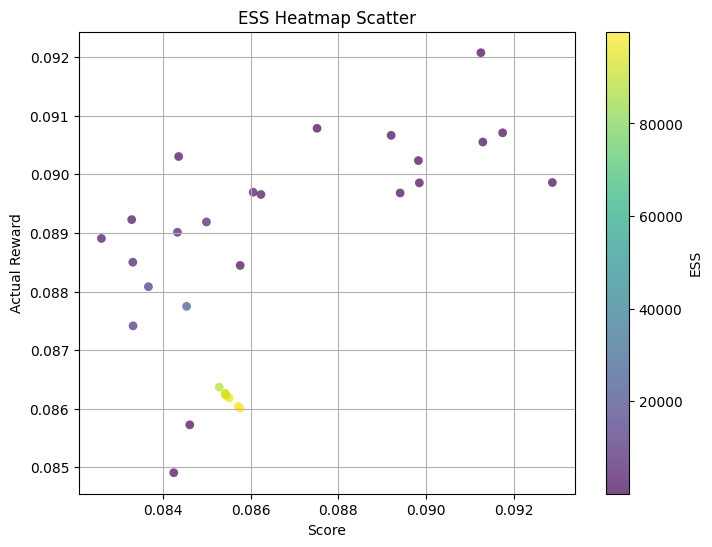

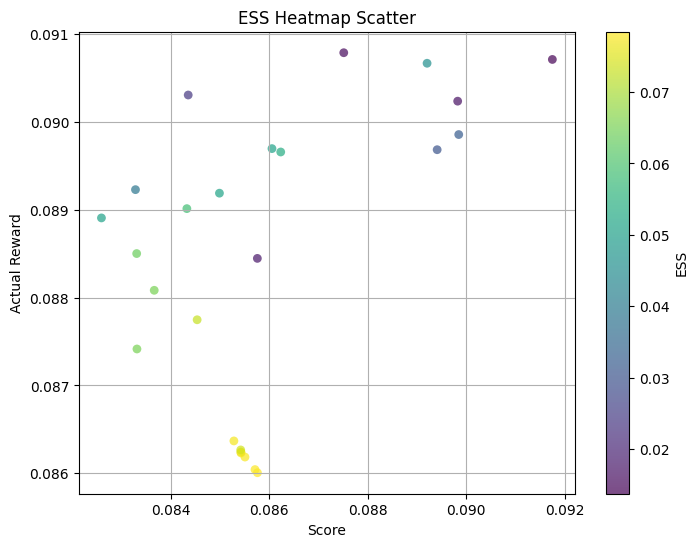

Correlation Metrics: {'pearson_score_actual': np.float64(0.5853070649634039), 'spearman_score_actual': np.float64(0.5421579532814237), 'spearman_est_actual': np.float64(0.48476084538375974)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9970613311668477), 'ndcg_est_actual': np.float64(0.9967199067623631)}
Error Metrics: {'mean_error': np.float64(0.0014314908782774587), 'mae': np.float64(0.002102699418514439), 'rmse': np.float64(0.002735487878039906), 'std_error': np.float64(0.002331035777570069), 'max_error': np.float64(0.005733058077276254), 'min_error': np.float64(-0.0032939415885550327)}
Random Item CTR: 0.07294626889755215
Optimal greedy CTR: 0.09999904053630068
Second Best greedy CTR: 0.09856665609217063
Optimal Stochastic CTR: 0.09986914393307014
second Best Stochastic CTR: 0.08577149743512977
Our Initial CTR: 0.08579963166825087
Simulation time for 200000 samples: 2.904967784881592 seconds
[Regression] Baseline regression model fit time: 0.48s
Num samples is 100000
{'gini': n

[I 2026-01-05 22:30:29,067] A new study created in memory with name: no-name-7b429365-f582-447a-be55-051c6d7f1234


Simulation time for 190000 samples: 2.6248488426208496 seconds


  0%|          | 0/30 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.08968467]


Best trial: 0. Best value: 0.0859145:   3%|▎         | 1/30 [00:16<08:05, 16.74s/it]

[I 2026-01-05 22:30:45,811] Trial 0 finished with value: 0.08591451558898891 and parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98}. Best is trial 0 with value: 0.08591451558898891.

[Regression] Optuna Trial 1
actual reward: [0.0859553]


Best trial: 0. Best value: 0.0859145:   7%|▋         | 2/30 [00:23<05:00, 10.73s/it]

[I 2026-01-05 22:30:52,330] Trial 1 finished with value: 0.08518296242929327 and parameters: {'lr': 0.0003816026078377047, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8796584556938062}. Best is trial 0 with value: 0.08591451558898891.

[Regression] Optuna Trial 2
actual reward: [0.08253597]


Best trial: 2. Best value: 0.086383:  10%|█         | 3/30 [00:30<04:08,  9.20s/it] 

[I 2026-01-05 22:30:59,705] Trial 2 finished with value: 0.0863829771813958 and parameters: {'lr': 0.06882471874722523, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9095380374403216}. Best is trial 2 with value: 0.0863829771813958.

[Regression] Optuna Trial 3
actual reward: [0.08752562]


Best trial: 2. Best value: 0.086383:  13%|█▎        | 4/30 [00:35<03:19,  7.66s/it]

[I 2026-01-05 22:31:05,009] Trial 3 finished with value: 0.08598725141627507 and parameters: {'lr': 0.03181286932762351, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.9918444995908999}. Best is trial 2 with value: 0.0863829771813958.

[Regression] Optuna Trial 4
actual reward: [0.09195902]


Best trial: 2. Best value: 0.086383:  17%|█▋        | 5/30 [00:49<04:02,  9.68s/it]

[I 2026-01-05 22:31:18,280] Trial 4 finished with value: 0.08534365154479366 and parameters: {'lr': 0.014129514553472099, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9118442240975896}. Best is trial 2 with value: 0.0863829771813958.

[Regression] Optuna Trial 5
actual reward: [0.08603989]


Best trial: 2. Best value: 0.086383:  20%|██        | 6/30 [00:58<03:48,  9.52s/it]

[I 2026-01-05 22:31:27,482] Trial 5 finished with value: 0.08529069337837085 and parameters: {'lr': 0.00037359689983815404, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.912997419039192}. Best is trial 2 with value: 0.0863829771813958.

[Regression] Optuna Trial 6
actual reward: [0.0863198]


Best trial: 2. Best value: 0.086383:  23%|██▎       | 7/30 [01:03<03:08,  8.20s/it]

[I 2026-01-05 22:31:32,955] Trial 6 finished with value: 0.08601720760676695 and parameters: {'lr': 0.0029154270316788878, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.9235780838394775}. Best is trial 2 with value: 0.0863829771813958.

[Regression] Optuna Trial 7


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0><function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        if w.is_alive():if w.is_alive():

        Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>   
 ^Traceback (mo

actual reward: [0.08637474]


Best trial: 2. Best value: 0.086383:  27%|██▋       | 8/30 [01:10<02:50,  7.75s/it]

[I 2026-01-05 22:31:39,747] Trial 7 finished with value: 0.08586600735369744 and parameters: {'lr': 0.0023079810195533075, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8840279705626907}. Best is trial 2 with value: 0.0863829771813958.

[Regression] Optuna Trial 8
actual reward: [0.08708307]


Best trial: 2. Best value: 0.086383:  30%|███       | 9/30 [01:26<03:33, 10.15s/it]

[I 2026-01-05 22:31:55,172] Trial 8 finished with value: 0.0861952951256697 and parameters: {'lr': 0.0011173261376214057, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9983064202507079}. Best is trial 2 with value: 0.0863829771813958.

[Regression] Optuna Trial 9
actual reward: [0.08709443]


Best trial: 9. Best value: 0.086451:  33%|███▎      | 10/30 [01:32<02:58,  8.92s/it]

[I 2026-01-05 22:32:01,333] Trial 9 finished with value: 0.08645097068542645 and parameters: {'lr': 0.009040917476969453, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9216420128012296}. Best is trial 9 with value: 0.08645097068542645.

[Regression] Optuna Trial 10


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>^
Traceback (most recent call last):
^  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^^    ^self._shutdown_workers()

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        assert self._parent_pid == os.ge

actual reward: [0.0858259]


Best trial: 9. Best value: 0.086451:  37%|███▋      | 11/30 [01:37<02:30,  7.94s/it]

[I 2026-01-05 22:32:07,044] Trial 10 finished with value: 0.08607906046697827 and parameters: {'lr': 0.010526644315596653, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8070878799187357}. Best is trial 9 with value: 0.08645097068542645.

[Regression] Optuna Trial 11
actual reward: [0.08178468]


Best trial: 9. Best value: 0.086451:  40%|████      | 12/30 [01:44<02:12,  7.36s/it]

[I 2026-01-05 22:32:13,092] Trial 11 finished with value: 0.08357567145613735 and parameters: {'lr': 0.06926343963109248, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.954960753258166}. Best is trial 9 with value: 0.08645097068542645.

[Regression] Optuna Trial 12
actual reward: [0.08461075]


Best trial: 9. Best value: 0.086451:  43%|████▎     | 13/30 [01:51<02:06,  7.43s/it]

[I 2026-01-05 22:32:20,679] Trial 12 finished with value: 0.08616317044536387 and parameters: {'lr': 0.09693225992517815, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8272726154977805}. Best is trial 9 with value: 0.08645097068542645.

[Regression] Optuna Trial 13
actual reward: [0.0881573]


Best trial: 13. Best value: 0.0865697:  47%|████▋     | 14/30 [01:57<01:52,  7.01s/it]

[I 2026-01-05 22:32:26,704] Trial 13 finished with value: 0.0865696741827618 and parameters: {'lr': 0.012829486796798786, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8529582252347836}. Best is trial 13 with value: 0.0865696741827618.

[Regression] Optuna Trial 14
actual reward: [0.0859059]


Best trial: 13. Best value: 0.0865697:  50%|█████     | 15/30 [02:01<01:31,  6.11s/it]

[I 2026-01-05 22:32:30,729] Trial 14 finished with value: 0.08594937018809966 and parameters: {'lr': 0.009070347124289276, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.8478547505618474}. Best is trial 13 with value: 0.0865696741827618.

[Regression] Optuna Trial 15
actual reward: [0.08888434]


Best trial: 15. Best value: 0.0872148:  53%|█████▎    | 16/30 [02:07<01:25,  6.08s/it]

[I 2026-01-05 22:32:36,749] Trial 15 finished with value: 0.08721482604997584 and parameters: {'lr': 0.022613490502461003, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8550969977010948}. Best is trial 15 with value: 0.08721482604997584.

[Regression] Optuna Trial 16
actual reward: [0.08419724]


Best trial: 15. Best value: 0.0872148:  57%|█████▋    | 17/30 [02:12<01:15,  5.81s/it]

[I 2026-01-05 22:32:41,919] Trial 16 finished with value: 0.08634097601487649 and parameters: {'lr': 0.027332645991698105, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.8602216954421933}. Best is trial 15 with value: 0.08721482604997584.

[Regression] Optuna Trial 17


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0><function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>^^


actual reward: [0.08677882]


Best trial: 15. Best value: 0.0872148:  60%|██████    | 18/30 [02:19<01:11,  5.96s/it]

[I 2026-01-05 22:32:48,246] Trial 17 finished with value: 0.08605213685093582 and parameters: {'lr': 0.022659100868043743, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8431301297385264}. Best is trial 15 with value: 0.08721482604997584.

[Regression] Optuna Trial 18
actual reward: [0.08622883]


Best trial: 15. Best value: 0.0872148:  63%|██████▎   | 19/30 [02:23<00:59,  5.39s/it]

[I 2026-01-05 22:32:52,286] Trial 18 finished with value: 0.086082883668301 and parameters: {'lr': 0.006107574134095478, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.8069812081319059}. Best is trial 15 with value: 0.08721482604997584.

[Regression] Optuna Trial 19
actual reward: [0.0864107]


Best trial: 15. Best value: 0.0872148:  67%|██████▋   | 20/30 [02:31<01:02,  6.21s/it]

[I 2026-01-05 22:33:00,422] Trial 19 finished with value: 0.08577226411605691 and parameters: {'lr': 0.0009939585810147312, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.8718597772738542}. Best is trial 15 with value: 0.08721482604997584.

[Regression] Optuna Trial 20
actual reward: [0.08585299]


Best trial: 15. Best value: 0.0872148:  70%|███████   | 21/30 [02:41<01:06,  7.37s/it]

[I 2026-01-05 22:33:10,506] Trial 20 finished with value: 0.08510061570305712 and parameters: {'lr': 0.00011187377998973447, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8287895515347348}. Best is trial 15 with value: 0.08721482604997584.

[Regression] Optuna Trial 21
actual reward: [0.08677763]


Best trial: 15. Best value: 0.0872148:  73%|███████▎  | 22/30 [02:47<00:55,  6.93s/it]

[I 2026-01-05 22:33:16,417] Trial 21 finished with value: 0.08601904113257682 and parameters: {'lr': 0.006137696427018802, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9345622318502815}. Best is trial 15 with value: 0.08721482604997584.

[Regression] Optuna Trial 22
actual reward: [0.08690395]


Best trial: 22. Best value: 0.0876382:  77%|███████▋  | 23/30 [02:53<00:47,  6.83s/it]

[I 2026-01-05 22:33:23,012] Trial 22 finished with value: 0.08763816638774503 and parameters: {'lr': 0.03927847727932829, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8886917131875064}. Best is trial 22 with value: 0.08763816638774503.

[Regression] Optuna Trial 23
actual reward: [0.08551104]


Best trial: 23. Best value: 0.0879208:  80%|████████  | 24/30 [03:00<00:40,  6.77s/it]

[I 2026-01-05 22:33:29,651] Trial 23 finished with value: 0.0879207729305191 and parameters: {'lr': 0.04255699432571395, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.891525952893373}. Best is trial 23 with value: 0.0879207729305191.

[Regression] Optuna Trial 24
actual reward: [0.08592801]


Best trial: 23. Best value: 0.0879208:  83%|████████▎ | 25/30 [03:08<00:35,  7.12s/it]

[I 2026-01-05 22:33:37,590] Trial 24 finished with value: 0.08507277104109005 and parameters: {'lr': 0.05467764233829255, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8965457733205401}. Best is trial 23 with value: 0.0879207729305191.

[Regression] Optuna Trial 25
actual reward: [0.08651305]


Best trial: 23. Best value: 0.0879208:  87%|████████▋ | 26/30 [03:15<00:28,  7.00s/it]

[I 2026-01-05 22:33:44,306] Trial 25 finished with value: 0.08609296248024753 and parameters: {'lr': 0.03885273145103679, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8920444249730752}. Best is trial 23 with value: 0.0879207729305191.

[Regression] Optuna Trial 26
actual reward: [0.08607901]


Best trial: 23. Best value: 0.0879208:  90%|█████████ | 27/30 [03:21<00:20,  6.92s/it]

[I 2026-01-05 22:33:51,020] Trial 26 finished with value: 0.08711118445294462 and parameters: {'lr': 0.021274450668559642, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9460982906309581}. Best is trial 23 with value: 0.0879207729305191.

[Regression] Optuna Trial 27
actual reward: [0.08461754]


Best trial: 23. Best value: 0.0879208:  93%|█████████▎| 28/30 [03:36<00:18,  9.23s/it]

[I 2026-01-05 22:34:05,640] Trial 27 finished with value: 0.08620423232319646 and parameters: {'lr': 0.046001929757099304, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8668200738970473}. Best is trial 23 with value: 0.0879207729305191.

[Regression] Optuna Trial 28
actual reward: [0.08092156]


Best trial: 23. Best value: 0.0879208:  97%|█████████▋| 29/30 [03:45<00:09,  9.02s/it]

[I 2026-01-05 22:34:14,193] Trial 28 finished with value: 0.08697191174292718 and parameters: {'lr': 0.09091445637230428, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8324937383381261}. Best is trial 23 with value: 0.0879207729305191.

[Regression] Optuna Trial 29
actual reward: [0.08814503]


Best trial: 23. Best value: 0.0879208: 100%|██████████| 30/30 [04:01<00:00,  8.05s/it]


[I 2026-01-05 22:34:30,547] Trial 29 finished with value: 0.08773198435549524 and parameters: {'lr': 0.021230159038069074, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9621964211798081}. Best is trial 23 with value: 0.0879207729305191.
Num samples is 100000
{'gini': np.float64(0.9978780341224537), 'ess': np.float64(19.925110028869998), 'max_wi': np.float64(23384.482920951956), 'min_wi': np.float64(5.545591183283299e-19)}
Eval time: 36.90182328224182 seconds
Evaluation total results time: 72.93 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_diff_to_real
0,0.08579963,0.08683000,0.08757145,0.08757145,0.08683187,0.08683187,0.88650375,0.00000000,0.82685190,0.82685190
90000,0.08836588,0.09367968,0.08634656,0.08634656,0.09446851,0.09536624,1.07264852,0.50617145,1.12805902,1.12805902


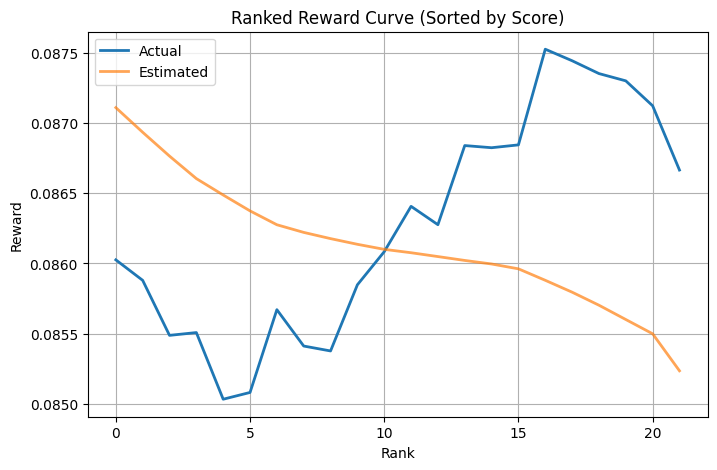

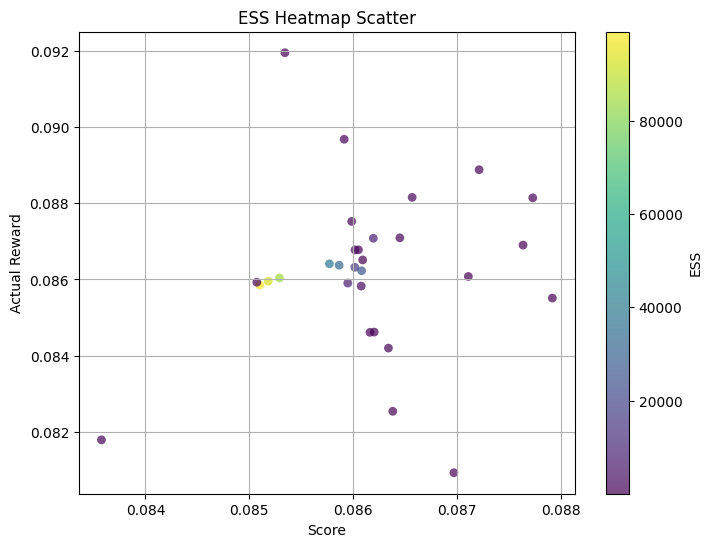

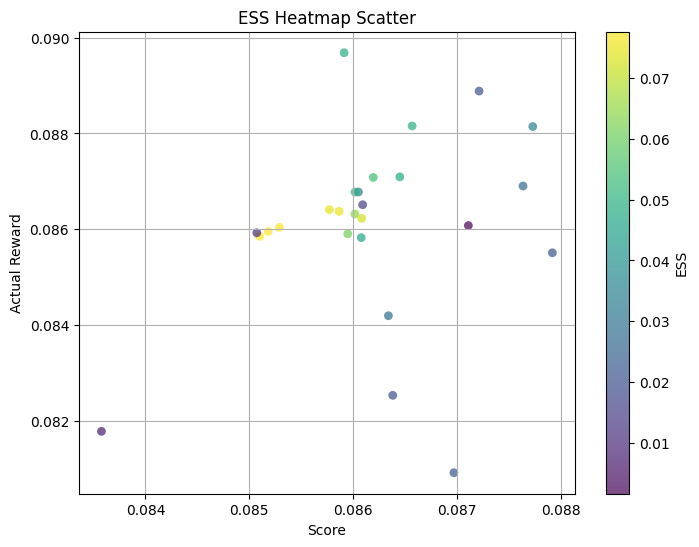

Correlation Metrics: {'pearson_score_actual': np.float64(0.13750101823385874), 'spearman_score_actual': np.float64(0.0825361512791991), 'spearman_est_actual': np.float64(0.11368186874304784)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9895639363269486), 'ndcg_est_actual': np.float64(0.9900023712679843)}
Error Metrics: {'mean_error': np.float64(-0.00035436395558866067), 'mae': np.float64(0.0014590820400098574), 'rmse': np.float64(0.0021516386506876843), 'std_error': np.float64(0.002122257069752078), 'max_error': np.float64(0.0064005932051489495), 'min_error': np.float64(-0.006149034440756526)}
Random Item CTR: 0.0730643696143998
Optimal greedy CTR: 0.09999910304006793
Second Best greedy CTR: 0.09815466674393501
Optimal Stochastic CTR: 0.09986423260577787
second Best Stochastic CTR: 0.0858240995424377
Our Initial CTR: 0.08585886101487139
Simulation time for 200000 samples: 2.734048366546631 seconds
[Regression] Baseline regression model fit time: 0.44s
Num samples is 100000
{'gini'

[I 2026-01-05 22:37:06,950] A new study created in memory with name: no-name-17f74303-2500-4546-82d9-f161cbcebe59


Simulation time for 230000 samples: 3.0625483989715576 seconds


  0%|          | 0/30 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.09024639]


Best trial: 0. Best value: 0.0861841:   3%|▎         | 1/30 [00:21<10:29, 21.71s/it]

[I 2026-01-05 22:37:28,658] Trial 0 finished with value: 0.08618411681481082 and parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98}. Best is trial 0 with value: 0.08618411681481082.

[Regression] Optuna Trial 1


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>
self._shutdown_workers()
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        self._shutdown_workers()
if w.is_alive():  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

     if w.is_alive(): 
          ^ ^ ^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^

actual reward: [0.08243166]


Best trial: 0. Best value: 0.0861841:   7%|▋         | 2/30 [00:26<05:35, 11.97s/it]

[I 2026-01-05 22:37:33,807] Trial 1 finished with value: 0.0845248821196938 and parameters: {'lr': 0.053042778505767677, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9658476800224619}. Best is trial 0 with value: 0.08618411681481082.

[Regression] Optuna Trial 2
actual reward: [0.08782024]


Best trial: 0. Best value: 0.0861841:  10%|█         | 3/30 [00:37<05:06, 11.37s/it]

[I 2026-01-05 22:37:44,461] Trial 2 finished with value: 0.08562464487126081 and parameters: {'lr': 0.019773065907636826, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.985811010298529}. Best is trial 0 with value: 0.08618411681481082.

[Regression] Optuna Trial 3
actual reward: [0.08112501]


Best trial: 0. Best value: 0.0861841:  13%|█▎        | 4/30 [00:55<06:01, 13.91s/it]

[I 2026-01-05 22:38:02,269] Trial 3 finished with value: 0.08272164757879281 and parameters: {'lr': 0.05816640077237052, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9051705027516086}. Best is trial 0 with value: 0.08618411681481082.

[Regression] Optuna Trial 4


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>assert self._parent_pid == os.getpid(), 'can only test a child process'

 Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
       self._shutdown_workers() 
   File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/datalo

actual reward: [0.08718252]


Best trial: 0. Best value: 0.0861841:  17%|█▋        | 5/30 [01:04<05:07, 12.31s/it]

[I 2026-01-05 22:38:11,742] Trial 4 finished with value: 0.08280834470620776 and parameters: {'lr': 0.005937417284043651, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8329336859469904}. Best is trial 0 with value: 0.08618411681481082.

[Regression] Optuna Trial 5
actual reward: [0.09052865]


Best trial: 0. Best value: 0.0861841:  20%|██        | 6/30 [01:28<06:24, 16.02s/it]

[I 2026-01-05 22:38:34,956] Trial 5 finished with value: 0.08485785819941163 and parameters: {'lr': 0.010967297069228499, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9902417134217458}. Best is trial 0 with value: 0.08618411681481082.

[Regression] Optuna Trial 6
actual reward: [0.08622122]


Best trial: 0. Best value: 0.0861841:  23%|██▎       | 7/30 [01:44<06:14, 16.30s/it]

[I 2026-01-05 22:38:51,828] Trial 6 finished with value: 0.08395984075021207 and parameters: {'lr': 0.0003119944525447811, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8633033526132576}. Best is trial 0 with value: 0.08618411681481082.

[Regression] Optuna Trial 7
actual reward: [0.08926807]


Best trial: 0. Best value: 0.0861841:  27%|██▋       | 8/30 [01:59<05:49, 15.89s/it]

[I 2026-01-05 22:39:06,860] Trial 7 finished with value: 0.08573518123714295 and parameters: {'lr': 0.002642703061172654, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9774489963985027}. Best is trial 0 with value: 0.08618411681481082.

[Regression] Optuna Trial 8


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0> 
^Traceback (most recent call last):
^  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^    ^self._shutdown_workers()^
^  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert sel

actual reward: [0.08591512]


Best trial: 0. Best value: 0.0861841:  30%|███       | 9/30 [02:05<04:26, 12.70s/it]

[I 2026-01-05 22:39:12,549] Trial 8 finished with value: 0.0831704803816102 and parameters: {'lr': 0.004885012422553697, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8662009943756621}. Best is trial 0 with value: 0.08618411681481082.

[Regression] Optuna Trial 9


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>Traceback (most recent call last):

  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()    
self._shutdown_workers()
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive


actual reward: [0.08876372]


Best trial: 0. Best value: 0.0861841:  33%|███▎      | 10/30 [02:14<03:50, 11.55s/it]

[I 2026-01-05 22:39:21,501] Trial 9 finished with value: 0.08342314496871076 and parameters: {'lr': 0.008586403583121986, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8375271433350795}. Best is trial 0 with value: 0.08618411681481082.

[Regression] Optuna Trial 10
actual reward: [0.08650188]


Best trial: 0. Best value: 0.0861841:  37%|███▋      | 11/30 [02:27<03:45, 11.85s/it]

[I 2026-01-05 22:39:34,056] Trial 10 finished with value: 0.08373475352688296 and parameters: {'lr': 0.0007688709099397244, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9338611224318527}. Best is trial 0 with value: 0.08618411681481082.

[Regression] Optuna Trial 11


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>self._shutdown_workers()
Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

Traceback (most recent call last):
        Exception ignored in:   File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
if w.is_alive():self._shutdown_workers()<fun

actual reward: [0.08647444]


Best trial: 0. Best value: 0.0861841:  40%|████      | 12/30 [02:38<03:32, 11.80s/it]

[I 2026-01-05 22:39:45,722] Trial 11 finished with value: 0.08327991101385249 and parameters: {'lr': 0.001431267822867585, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9435812048938511}. Best is trial 0 with value: 0.08618411681481082.

[Regression] Optuna Trial 12
actual reward: [0.08610563]


Best trial: 0. Best value: 0.0861841:  43%|████▎     | 13/30 [02:58<04:02, 14.26s/it]

[I 2026-01-05 22:40:05,651] Trial 12 finished with value: 0.08414551660851621 and parameters: {'lr': 0.00010146328852705248, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.99934379714274}. Best is trial 0 with value: 0.08618411681481082.

[Regression] Optuna Trial 13


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0><function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>    self._shutdown_workers()
self._shutdown_workers()
Traceback (most recent call last):

  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/roee/Documents/code/OPC/.venv/l

actual reward: [0.08741992]


Best trial: 0. Best value: 0.0861841:  47%|████▋     | 14/30 [03:12<03:45, 14.12s/it]

[I 2026-01-05 22:40:19,435] Trial 13 finished with value: 0.08362738310823638 and parameters: {'lr': 0.001792815894692083, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9484762404657697}. Best is trial 0 with value: 0.08618411681481082.

[Regression] Optuna Trial 14
actual reward: [0.08633111]


Best trial: 0. Best value: 0.0861841:  50%|█████     | 15/30 [03:27<03:33, 14.24s/it]

[I 2026-01-05 22:40:33,967] Trial 14 finished with value: 0.08360468006981683 and parameters: {'lr': 0.0005343755811748094, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9098000921069127}. Best is trial 0 with value: 0.08618411681481082.

[Regression] Optuna Trial 15
actual reward: [0.08809949]


Best trial: 0. Best value: 0.0861841:  53%|█████▎    | 16/30 [03:39<03:13, 13.79s/it]

[I 2026-01-05 22:40:46,707] Trial 15 finished with value: 0.08479349711873932 and parameters: {'lr': 0.0023243087204055783, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.9671678089276713}. Best is trial 0 with value: 0.08618411681481082.

[Regression] Optuna Trial 16
actual reward: [0.09118711]


Best trial: 0. Best value: 0.0861841:  57%|█████▋    | 17/30 [03:55<03:08, 14.48s/it]

[I 2026-01-05 22:41:02,783] Trial 16 finished with value: 0.08572042383989757 and parameters: {'lr': 0.019235773901986178, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8016809372372052}. Best is trial 0 with value: 0.08618411681481082.

[Regression] Optuna Trial 17
actual reward: [0.09039998]


Best trial: 17. Best value: 0.086841:  60%|██████    | 18/30 [04:15<03:13, 16.14s/it]

[I 2026-01-05 22:41:22,792] Trial 17 finished with value: 0.086841015683674 and parameters: {'lr': 0.0036132350148818417, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9243126056391795}. Best is trial 17 with value: 0.086841015683674.

[Regression] Optuna Trial 18
actual reward: [0.08711571]


Best trial: 17. Best value: 0.086841:  63%|██████▎   | 19/30 [04:35<03:10, 17.35s/it]

[I 2026-01-05 22:41:42,948] Trial 18 finished with value: 0.08393913345044125 and parameters: {'lr': 0.0009060069602097179, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9287413507730089}. Best is trial 17 with value: 0.086841015683674.

[Regression] Optuna Trial 19
actual reward: [0.08618354]


Best trial: 17. Best value: 0.086841:  67%|██████▋   | 20/30 [04:51<02:46, 16.66s/it]

[I 2026-01-05 22:41:57,996] Trial 19 finished with value: 0.08403482834805694 and parameters: {'lr': 0.00024466336313907203, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8875908160133059}. Best is trial 17 with value: 0.086841015683674.

[Regression] Optuna Trial 20
actual reward: [0.09059273]


Best trial: 17. Best value: 0.086841:  70%|███████   | 21/30 [05:10<02:37, 17.54s/it]

[I 2026-01-05 22:42:17,600] Trial 20 finished with value: 0.08598467339452544 and parameters: {'lr': 0.003572844277062547, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.917086662898545}. Best is trial 17 with value: 0.086841015683674.

[Regression] Optuna Trial 21
actual reward: [0.09028123]


Best trial: 17. Best value: 0.086841:  73%|███████▎  | 22/30 [05:30<02:25, 18.14s/it]

[I 2026-01-05 22:42:37,135] Trial 21 finished with value: 0.08585745185105371 and parameters: {'lr': 0.003831457199409988, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9182203259294879}. Best is trial 17 with value: 0.086841015683674.

[Regression] Optuna Trial 22
actual reward: [0.09071493]


Best trial: 17. Best value: 0.086841:  77%|███████▋  | 23/30 [05:47<02:05, 17.99s/it]

[I 2026-01-05 22:42:54,769] Trial 22 finished with value: 0.08469107843435182 and parameters: {'lr': 0.012354423891627594, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8909592179883112}. Best is trial 17 with value: 0.086841015683674.

[Regression] Optuna Trial 23
actual reward: [0.09176366]


Best trial: 17. Best value: 0.086841:  80%|████████  | 24/30 [06:12<02:00, 20.00s/it]

[I 2026-01-05 22:43:19,474] Trial 23 finished with value: 0.08592481829665535 and parameters: {'lr': 0.0035930370214237095, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9586673954156568}. Best is trial 17 with value: 0.086841015683674.

[Regression] Optuna Trial 24
actual reward: [0.08749857]


Best trial: 17. Best value: 0.086841:  83%|████████▎ | 25/30 [06:32<01:39, 19.93s/it]

[I 2026-01-05 22:43:39,221] Trial 24 finished with value: 0.08432345318739813 and parameters: {'lr': 0.0013687499150689642, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8757902250626342}. Best is trial 17 with value: 0.086841015683674.

[Regression] Optuna Trial 25
actual reward: [0.08824718]


Best trial: 17. Best value: 0.086841:  87%|████████▋ | 26/30 [06:39<01:04, 16.13s/it]

[I 2026-01-05 22:43:46,508] Trial 25 finished with value: 0.0846050092691689 and parameters: {'lr': 0.006531354201523647, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9223665458101178}. Best is trial 17 with value: 0.086841015683674.

[Regression] Optuna Trial 26
actual reward: [0.08596964]


Best trial: 17. Best value: 0.086841:  90%|█████████ | 27/30 [07:03<00:55, 18.62s/it]

[I 2026-01-05 22:44:10,933] Trial 26 finished with value: 0.0838437264979904 and parameters: {'lr': 0.019966802282527785, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9428925898036361}. Best is trial 17 with value: 0.086841015683674.

[Regression] Optuna Trial 27
actual reward: [0.08713001]


Best trial: 17. Best value: 0.086841:  93%|█████████▎| 28/30 [07:24<00:38, 19.05s/it]

[I 2026-01-05 22:44:30,968] Trial 27 finished with value: 0.08405908650433613 and parameters: {'lr': 0.000996525777459849, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8979193236064398}. Best is trial 17 with value: 0.086841015683674.

[Regression] Optuna Trial 28
actual reward: [0.08409341]


Best trial: 17. Best value: 0.086841:  97%|█████████▋| 29/30 [07:29<00:15, 15.01s/it]

[I 2026-01-05 22:44:36,568] Trial 28 finished with value: 0.08397892104021779 and parameters: {'lr': 0.03401867380404255, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9546103528616601}. Best is trial 17 with value: 0.086841015683674.

[Regression] Optuna Trial 29
actual reward: [0.08902413]


Best trial: 17. Best value: 0.086841: 100%|██████████| 30/30 [07:44<00:00, 15.50s/it]


[I 2026-01-05 22:44:51,929] Trial 29 finished with value: 0.08505395199262389 and parameters: {'lr': 0.002271168913033466, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9672013133409085}. Best is trial 17 with value: 0.086841015683674.


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0><function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        Exception ignored in: if w.is_alive():if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>Exception ignored in: 


 <func

Num samples is 100000
{'gini': np.float64(0.9787067993340135), 'ess': np.float64(357.5845537382688), 'max_wi': np.float64(2983.02076213588), 'min_wi': np.float64(1.2196904024662276e-07)}
Eval time: 39.751230001449585 seconds
Evaluation total results time: 77.27 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_diff_to_real
0,0.08585886,0.08682000,0.08776993,0.08776993,0.08682900,0.08682900,0.82774338,0.00000000,0.89622708,0.89622708
130000,0.08850065,0.08026061,0.08765829,0.08765829,0.07990190,0.08017768,0.94194512,0.37586146,1.04147243,1.04147243


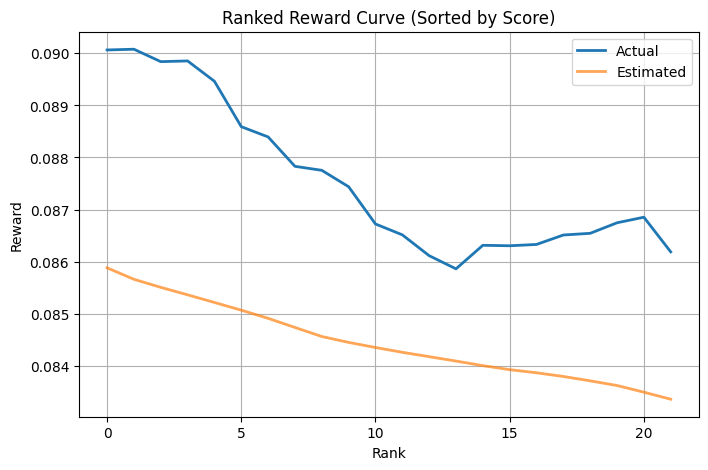

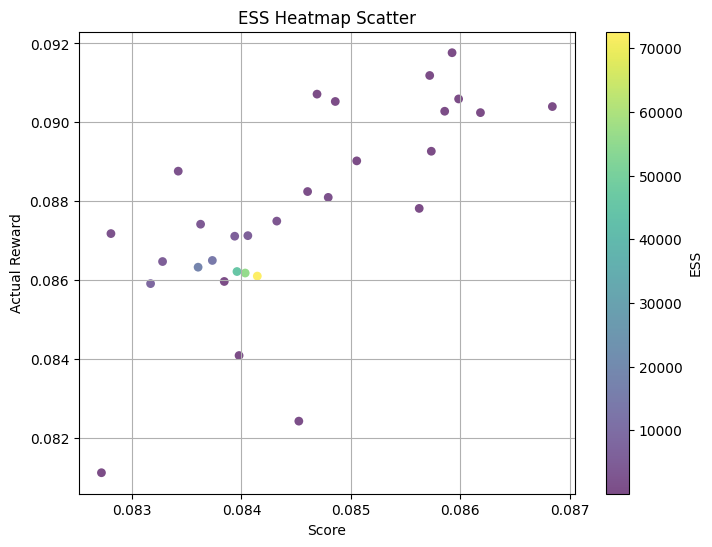

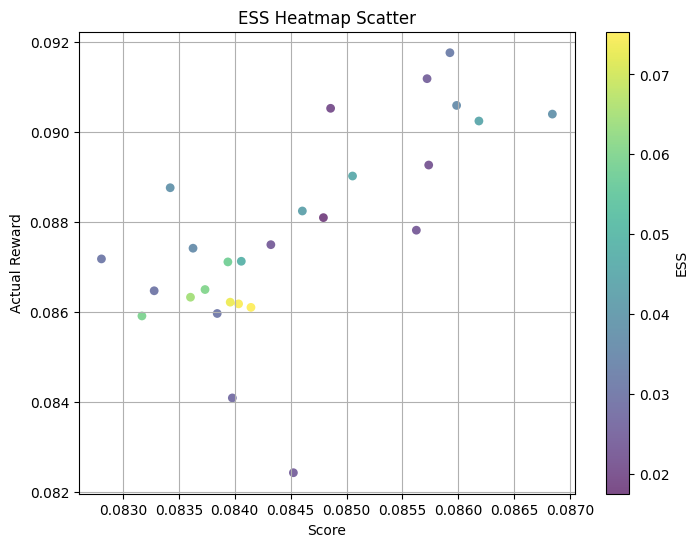

Correlation Metrics: {'pearson_score_actual': np.float64(0.7155555326953434), 'spearman_score_actual': np.float64(0.7334816462736374), 'spearman_est_actual': np.float64(0.6680756395995551)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9977021714869251), 'ndcg_est_actual': np.float64(0.9975188166577105)}
Error Metrics: {'mean_error': np.float64(0.002762066099613676), 'mae': np.float64(0.0030300319986131244), 'rmse': np.float64(0.003351981663026402), 'std_error': np.float64(0.0018991503180712521), 'max_error': np.float64(0.005758965261434892), 'min_error': np.float64(-0.002250970148164791)}
Random Item CTR: 0.07296743362455077
Optimal greedy CTR: 0.09999896191732437
Second Best greedy CTR: 0.0993924911903673
Optimal Stochastic CTR: 0.0998601282466506
second Best Stochastic CTR: 0.08590033019470934
Our Initial CTR: 0.08592593303058893
Simulation time for 200000 samples: 2.9335625171661377 seconds
[Regression] Baseline regression model fit time: 0.32s
Num samples is 100000
{'gini': np.

[I 2026-01-05 22:47:41,513] A new study created in memory with name: no-name-d98547d2-5989-4804-9e3f-1b1b9d85ce44


Simulation time for 270000 samples: 3.7077035903930664 seconds


  0%|          | 0/30 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.09195348]


Best trial: 0. Best value: 0.0847431:   3%|▎         | 1/30 [00:27<13:26, 27.82s/it]

[I 2026-01-05 22:48:09,332] Trial 0 finished with value: 0.08474311074888301 and parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98}. Best is trial 0 with value: 0.08474311074888301.

[Regression] Optuna Trial 1
actual reward: [0.08597356]


Best trial: 0. Best value: 0.0847431:   7%|▋         | 2/30 [00:32<06:29, 13.92s/it]

[I 2026-01-05 22:48:13,527] Trial 1 finished with value: 0.08468482621150787 and parameters: {'lr': 0.00016103548814994285, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.936043298915999}. Best is trial 0 with value: 0.08474311074888301.

[Regression] Optuna Trial 2
actual reward: [0.08764814]


Best trial: 0. Best value: 0.0847431:  10%|█         | 3/30 [00:44<05:55, 13.17s/it]

[I 2026-01-05 22:48:25,803] Trial 2 finished with value: 0.08342947215122386 and parameters: {'lr': 0.0010860534492420743, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9902165665963621}. Best is trial 0 with value: 0.08474311074888301.

[Regression] Optuna Trial 3
actual reward: [0.08690824]


Best trial: 0. Best value: 0.0847431:  13%|█▎        | 4/30 [00:59<06:03, 13.99s/it]

[I 2026-01-05 22:48:41,059] Trial 3 finished with value: 0.08422840390581905 and parameters: {'lr': 0.0003801209584831232, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.995088226011321}. Best is trial 0 with value: 0.08474311074888301.

[Regression] Optuna Trial 4
actual reward: [0.08680023]


Best trial: 0. Best value: 0.0847431:  17%|█▋        | 5/30 [01:30<08:19, 19.98s/it]

[I 2026-01-05 22:49:11,658] Trial 4 finished with value: 0.08432804138855975 and parameters: {'lr': 0.00017676059961029263, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9539291249072006}. Best is trial 0 with value: 0.08474311074888301.

[Regression] Optuna Trial 5


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0><function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        if w.is_alive():if w.is_alive():

    Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>  
  Traceback (most re

actual reward: [0.0861302]


Best trial: 0. Best value: 0.0847431:  20%|██        | 6/30 [01:39<06:31, 16.30s/it]

[I 2026-01-05 22:49:20,805] Trial 5 finished with value: 0.08467969730820718 and parameters: {'lr': 0.00027332603972149644, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8852744362798838}. Best is trial 0 with value: 0.08474311074888301.

[Regression] Optuna Trial 6


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0><function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

actual reward: [0.08971901]


Best trial: 0. Best value: 0.0847431:  23%|██▎       | 7/30 [01:50<05:36, 14.62s/it]

[I 2026-01-05 22:49:31,956] Trial 6 finished with value: 0.08215691909078796 and parameters: {'lr': 0.003855233626676692, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9281937519021881}. Best is trial 0 with value: 0.08474311074888301.

[Regression] Optuna Trial 7
actual reward: [0.09007306]


Best trial: 0. Best value: 0.0847431:  27%|██▋       | 8/30 [02:17<06:50, 18.66s/it]

[I 2026-01-05 22:49:59,277] Trial 7 finished with value: 0.08207026935667568 and parameters: {'lr': 0.02291788025461686, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8906563560290516}. Best is trial 0 with value: 0.08474311074888301.

[Regression] Optuna Trial 8


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>self._shutdown_workers()
Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

    Traceback (most recent call last):
      File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
if w.is_alive():self._shutdown_workers()

       File "/home/roee/

actual reward: [0.08658955]


Best trial: 0. Best value: 0.0847431:  30%|███       | 9/30 [02:30<05:52, 16.78s/it]

[I 2026-01-05 22:50:11,921] Trial 8 finished with value: 0.0844681985546289 and parameters: {'lr': 0.00034750835046749173, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.956668525281514}. Best is trial 0 with value: 0.08474311074888301.

[Regression] Optuna Trial 9


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>^
^Traceback (most recent call last):
^  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
^    ^^self._shutdown_workers()^

  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._par

actual reward: [0.08744619]


Best trial: 0. Best value: 0.0847431:  33%|███▎      | 10/30 [02:39<04:47, 14.35s/it]

[I 2026-01-05 22:50:20,837] Trial 9 finished with value: 0.08367602038707608 and parameters: {'lr': 0.0017025268396707745, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.858955298823516}. Best is trial 0 with value: 0.08474311074888301.

[Regression] Optuna Trial 10


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>

 Traceback (most recent call last):
   File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>      
self._shutdown_workers() Traceba

actual reward: [0.09071852]


Best trial: 0. Best value: 0.0847431:  37%|███▋      | 11/30 [02:54<04:38, 14.65s/it]

[I 2026-01-05 22:50:36,151] Trial 10 finished with value: 0.08160586050771605 and parameters: {'lr': 0.01053001404701518, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.84410149961225}. Best is trial 0 with value: 0.08474311074888301.

[Regression] Optuna Trial 11
actual reward: [0.08405899]


Best trial: 0. Best value: 0.0847431:  40%|████      | 12/30 [02:58<03:26, 11.48s/it]

[I 2026-01-05 22:50:40,398] Trial 11 finished with value: 0.08298747686538836 and parameters: {'lr': 0.0929390850512318, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9414079736861254}. Best is trial 0 with value: 0.08474311074888301.

[Regression] Optuna Trial 12


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

      File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

     if w.is_alive(): 
          ^ ^ ^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^

actual reward: [0.08613756]


Best trial: 0. Best value: 0.0847431:  43%|████▎     | 13/30 [03:16<03:45, 13.27s/it]

[I 2026-01-05 22:50:57,777] Trial 12 finished with value: 0.08467532834630796 and parameters: {'lr': 0.00011343935139098836, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8154136267129705}. Best is trial 0 with value: 0.08474311074888301.

[Regression] Optuna Trial 13
actual reward: [0.08621741]


Best trial: 0. Best value: 0.0847431:  47%|████▋     | 14/30 [03:20<02:49, 10.60s/it]

[I 2026-01-05 22:51:02,205] Trial 13 finished with value: 0.08466900740248147 and parameters: {'lr': 0.0009487552960745754, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9216997061261295}. Best is trial 0 with value: 0.08474311074888301.

[Regression] Optuna Trial 14
actual reward: [0.09131355]


Best trial: 14. Best value: 0.0867276:  50%|█████     | 15/30 [03:42<03:29, 13.94s/it]

[I 2026-01-05 22:51:23,877] Trial 14 finished with value: 0.0867275588585575 and parameters: {'lr': 0.004581499731903505, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9708372871443208}. Best is trial 14 with value: 0.0867275588585575.

[Regression] Optuna Trial 15
actual reward: [0.0926801]


Best trial: 14. Best value: 0.0867276:  53%|█████▎    | 16/30 [04:03<03:47, 16.22s/it]

[I 2026-01-05 22:51:45,414] Trial 15 finished with value: 0.08558843456872527 and parameters: {'lr': 0.00518527715986149, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9752644831573162}. Best is trial 14 with value: 0.0867275588585575.

[Regression] Optuna Trial 16
actual reward: [0.0916266]


Best trial: 14. Best value: 0.0867276:  57%|█████▋    | 17/30 [04:25<03:52, 17.85s/it]

[I 2026-01-05 22:52:07,040] Trial 16 finished with value: 0.0844454491476643 and parameters: {'lr': 0.009659083746408696, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9693096277347394}. Best is trial 14 with value: 0.0867275588585575.

[Regression] Optuna Trial 17
actual reward: [0.09032564]


Best trial: 17. Best value: 0.0869978:  60%|██████    | 18/30 [04:44<03:37, 18.10s/it]

[I 2026-01-05 22:52:25,711] Trial 17 finished with value: 0.08699776901201157 and parameters: {'lr': 0.007024077208137415, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9077218416474458}. Best is trial 17 with value: 0.08699776901201157.

[Regression] Optuna Trial 18
actual reward: [0.08528878]


Best trial: 17. Best value: 0.0869978:  63%|██████▎   | 19/30 [04:56<02:58, 16.26s/it]

[I 2026-01-05 22:52:37,711] Trial 18 finished with value: 0.08176490768554916 and parameters: {'lr': 0.03671913103099391, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9125242941143111}. Best is trial 17 with value: 0.08699776901201157.

[Regression] Optuna Trial 19


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>^
^Traceback (most recent call last):
^  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>    ^
self._shutdown_workers()^Traceback (most recent call last):

^  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File

actual reward: [0.08966539]


Best trial: 17. Best value: 0.0869978:  67%|██████▋   | 20/30 [05:05<02:20, 14.08s/it]

[I 2026-01-05 22:52:46,703] Trial 19 finished with value: 0.08134320664735692 and parameters: {'lr': 0.009636341938725156, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.868648644214906}. Best is trial 17 with value: 0.08699776901201157.

[Regression] Optuna Trial 20


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0><function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

actual reward: [0.08929711]


Best trial: 17. Best value: 0.0869978:  70%|███████   | 21/30 [05:22<02:14, 14.94s/it]

[I 2026-01-05 22:53:03,653] Trial 20 finished with value: 0.08282942364853699 and parameters: {'lr': 0.017987101299467068, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9045521309308713}. Best is trial 17 with value: 0.08699776901201157.

[Regression] Optuna Trial 21
actual reward: [0.09089068]


Best trial: 17. Best value: 0.0869978:  73%|███████▎  | 22/30 [05:43<02:16, 17.01s/it]

[I 2026-01-05 22:53:25,485] Trial 21 finished with value: 0.08562225321329564 and parameters: {'lr': 0.00500965092713483, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9689184847736119}. Best is trial 17 with value: 0.08699776901201157.

[Regression] Optuna Trial 22
actual reward: [0.09119073]


Best trial: 17. Best value: 0.0869978:  77%|███████▋  | 23/30 [06:05<02:08, 18.36s/it]

[I 2026-01-05 22:53:46,984] Trial 22 finished with value: 0.08615264143452438 and parameters: {'lr': 0.005415949598217568, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9499820886246376}. Best is trial 17 with value: 0.08699776901201157.

[Regression] Optuna Trial 23
actual reward: [0.09047472]


Best trial: 17. Best value: 0.0869978:  80%|████████  | 24/30 [06:23<01:49, 18.33s/it]

[I 2026-01-05 22:54:05,240] Trial 23 finished with value: 0.08268928406509302 and parameters: {'lr': 0.002436292975176627, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9501953303343419}. Best is trial 17 with value: 0.08699776901201157.

[Regression] Optuna Trial 24
actual reward: [0.09156041]


Best trial: 17. Best value: 0.0869978:  83%|████████▎ | 25/30 [06:51<01:45, 21.11s/it]

[I 2026-01-05 22:54:32,830] Trial 24 finished with value: 0.08560713830582473 and parameters: {'lr': 0.00547402529659659, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9136619090669708}. Best is trial 17 with value: 0.08699776901201157.

[Regression] Optuna Trial 25
actual reward: [0.08736078]


Best trial: 17. Best value: 0.0869978:  87%|████████▋ | 26/30 [07:03<01:13, 18.45s/it]

[I 2026-01-05 22:54:45,096] Trial 25 finished with value: 0.08383984830107294 and parameters: {'lr': 0.0008549482480598754, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9349398408036518}. Best is trial 17 with value: 0.08699776901201157.

[Regression] Optuna Trial 26
actual reward: [0.08878972]


Best trial: 17. Best value: 0.0869978:  90%|█████████ | 27/30 [07:24<00:58, 19.34s/it]

[I 2026-01-05 22:55:06,513] Trial 26 finished with value: 0.08311648266618883 and parameters: {'lr': 0.028837465046325058, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8882811227588077}. Best is trial 17 with value: 0.08699776901201157.

[Regression] Optuna Trial 27
actual reward: [0.07867774]


Best trial: 17. Best value: 0.0869978:  93%|█████████▎| 28/30 [07:49<00:41, 20.93s/it]

[I 2026-01-05 22:55:31,139] Trial 27 finished with value: 0.08102570083629855 and parameters: {'lr': 0.05567150398157531, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9585150953740482}. Best is trial 17 with value: 0.08699776901201157.

[Regression] Optuna Trial 28


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

Traceback (most recent call last):
      File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
if w.is_alive():    
self._shutdown_workers() 
   File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
      if w.is_alive(): 
    ^ ^ ^ ^ ^ ^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>^^
^^

actual reward: [0.08932885]


Best trial: 17. Best value: 0.0869978:  97%|█████████▋| 29/30 [07:58<00:17, 17.39s/it]

[I 2026-01-05 22:55:40,274] Trial 28 finished with value: 0.0812204738263284 and parameters: {'lr': 0.01372263534520508, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.9830121199023069}. Best is trial 17 with value: 0.08699776901201157.

[Regression] Optuna Trial 29
actual reward: [0.09026014]


Best trial: 17. Best value: 0.0869978: 100%|██████████| 30/30 [08:26<00:00, 16.88s/it]


[I 2026-01-05 22:56:07,965] Trial 29 finished with value: 0.08269810899530537 and parameters: {'lr': 0.002214693448249571, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8255182864276827}. Best is trial 17 with value: 0.08699776901201157.


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0><function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0><function _MultiProcessingDataLoaderIter.__del__ at 0x777ed43f7ce0>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
            self._shutdown_workers()self._shutdown_workers()self._shutdown_workers()


  File "/home/roee/Documents/code/OPC/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/home/ro

Num samples is 100000
{'gini': np.float64(0.9847377182191577), 'ess': np.float64(422.29787448117884), 'max_wi': np.float64(1910.7404828604665), 'min_wi': np.float64(5.4675061751170676e-08)}
Eval time: 38.58084034919739 seconds
Evaluation total results time: 73.89 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_diff_to_real
0,0.08592593,0.08666000,0.08819609,0.08819609,0.08668094,0.08668094,0.83918950,0.00000000,0.75421425,0.75421425
170000,0.09095018,0.09899200,0.08500519,0.08500519,0.09908846,0.09929463,1.03645775,0.42907160,0.95097210,0.95097210


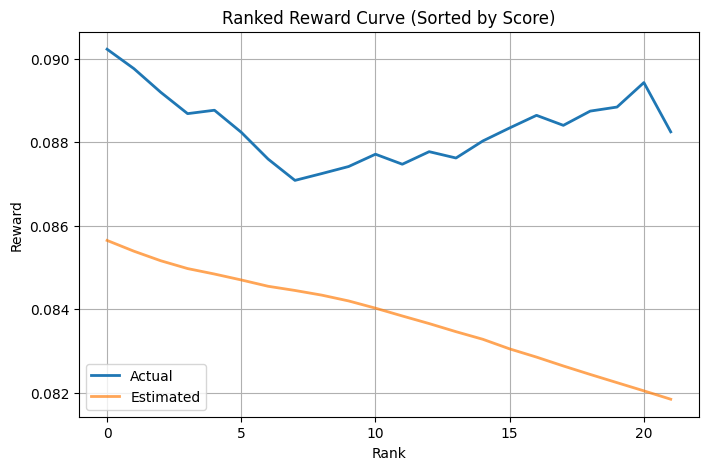

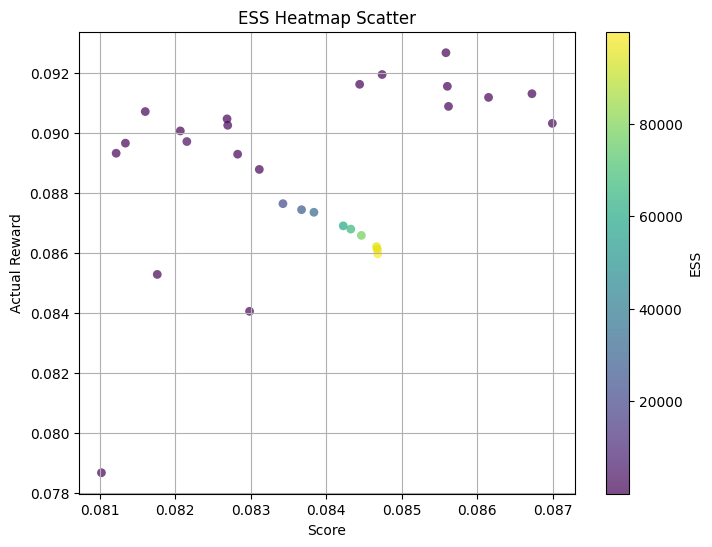

Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


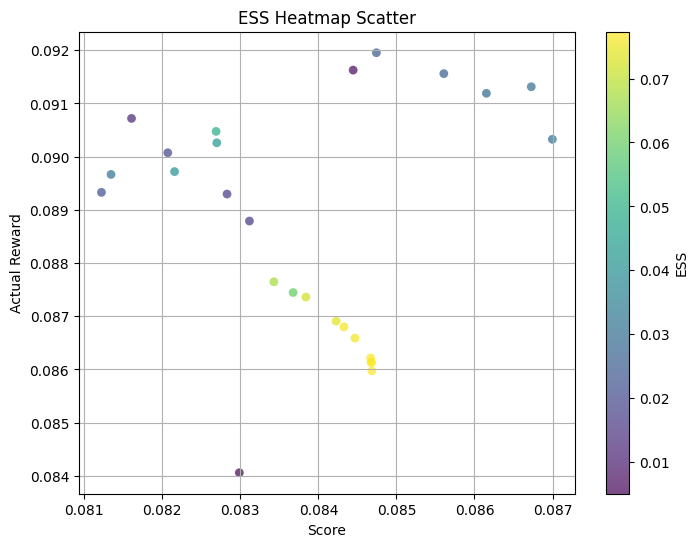

Correlation Metrics: {'pearson_score_actual': np.float64(0.3528620647597906), 'spearman_score_actual': np.float64(0.32858731924360396), 'spearman_est_actual': np.float64(0.14349276974416017)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9950659912854345), 'ndcg_est_actual': np.float64(0.9926267936673453)}
Error Metrics: {'mean_error': np.float64(0.004163913936291735), 'mae': np.float64(0.004325439034140027), 'rmse': np.float64(0.005142768545891602), 'std_error': np.float64(0.0030182592744440453), 'max_error': np.float64(0.008846051614908992), 'min_error': np.float64(-0.0024031612642845535)}
Random Item CTR: 0.07296133168894806
Optimal greedy CTR: 0.09999903155808942
Second Best greedy CTR: 0.09936114959176821
Optimal Stochastic CTR: 0.09986691424039554
second Best Stochastic CTR: 0.08604515975608076
Our Initial CTR: 0.08607542314056624
Simulation time for 200000 samples: 2.8176465034484863 seconds
[Regression] Baseline regression model fit time: 0.28s
Num samples is 100000
{'gini':

[I 2026-01-05 22:58:50,428] A new study created in memory with name: no-name-535074ed-af28-422b-a789-a1b3aaedfd4b


Simulation time for 310000 samples: 4.210423469543457 seconds


  0%|          | 0/30 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.09351319]


Best trial: 0. Best value: 0.0845758:   3%|▎         | 1/30 [00:33<16:19, 33.76s/it]

[I 2026-01-05 22:59:24,192] Trial 0 finished with value: 0.08457584567772278 and parameters: {'lr': 0.0025, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.98}. Best is trial 0 with value: 0.08457584567772278.

[Regression] Optuna Trial 1
actual reward: [0.08665661]


Best trial: 0. Best value: 0.0845758:   7%|▋         | 2/30 [00:44<09:30, 20.37s/it]

[I 2026-01-05 22:59:35,189] Trial 1 finished with value: 0.08404261405935796 and parameters: {'lr': 0.00037384602830303087, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8407327113311132}. Best is trial 0 with value: 0.08457584567772278.

[Regression] Optuna Trial 2
actual reward: [0.09241388]


Best trial: 0. Best value: 0.0845758:  10%|█         | 3/30 [00:55<07:14, 16.08s/it]

[I 2026-01-05 22:59:46,151] Trial 2 finished with value: 0.08409854974986668 and parameters: {'lr': 0.012821773675991755, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9112135847999704}. Best is trial 0 with value: 0.08457584567772278.

[Regression] Optuna Trial 3
actual reward: [0.08841203]


Best trial: 0. Best value: 0.0845758:  13%|█▎        | 4/30 [01:14<07:23, 17.06s/it]

[I 2026-01-05 23:00:04,725] Trial 3 finished with value: 0.08379297811203247 and parameters: {'lr': 0.033939397582322575, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8287857708922568}. Best is trial 0 with value: 0.08457584567772278.

[Regression] Optuna Trial 4
actual reward: [0.09024581]


Best trial: 4. Best value: 0.0847321:  17%|█▋        | 5/30 [01:28<06:44, 16.18s/it]

[I 2026-01-05 23:00:19,339] Trial 4 finished with value: 0.0847320929995727 and parameters: {'lr': 0.012981697502452212, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8773265261884531}. Best is trial 4 with value: 0.0847320929995727.

[Regression] Optuna Trial 5
actual reward: [0.09042562]


Best trial: 4. Best value: 0.0847321:  20%|██        | 6/30 [01:41<05:57, 14.88s/it]

[I 2026-01-05 23:00:31,693] Trial 5 finished with value: 0.08405473270798552 and parameters: {'lr': 0.02559464038719901, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8620528936107346}. Best is trial 4 with value: 0.0847320929995727.

[Regression] Optuna Trial 6
actual reward: [0.08395893]


Best trial: 6. Best value: 0.0854843:  23%|██▎       | 7/30 [02:18<08:32, 22.26s/it]

[I 2026-01-05 23:01:09,158] Trial 6 finished with value: 0.08548426697625028 and parameters: {'lr': 0.041889948374219506, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8624112248616562}. Best is trial 6 with value: 0.08548426697625028.

[Regression] Optuna Trial 7
actual reward: [0.0926557]


Best trial: 6. Best value: 0.0854843:  27%|██▋       | 8/30 [02:27<06:33, 17.90s/it]

[I 2026-01-05 23:01:17,713] Trial 7 finished with value: 0.08405241488771993 and parameters: {'lr': 0.014349455197979512, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8247933283840571}. Best is trial 6 with value: 0.08548426697625028.

[Regression] Optuna Trial 8
actual reward: [0.09172393]


Best trial: 6. Best value: 0.0854843:  30%|███       | 9/30 [02:44<06:10, 17.63s/it]

[I 2026-01-05 23:01:34,744] Trial 8 finished with value: 0.08481292987095597 and parameters: {'lr': 0.019136995164917348, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9209597394617981}. Best is trial 6 with value: 0.08548426697625028.

[Regression] Optuna Trial 9
actual reward: [0.0863644]


Best trial: 6. Best value: 0.0854843:  33%|███▎      | 10/30 [02:59<05:40, 17.01s/it]

[I 2026-01-05 23:01:50,361] Trial 9 finished with value: 0.08397430710560702 and parameters: {'lr': 0.00017673782902215428, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9056720398766089}. Best is trial 6 with value: 0.08548426697625028.

[Regression] Optuna Trial 10
actual reward: [0.08168215]


Best trial: 6. Best value: 0.0854843:  37%|███▋      | 11/30 [03:28<06:31, 20.58s/it]

[I 2026-01-05 23:02:19,057] Trial 10 finished with value: 0.08523245649921339 and parameters: {'lr': 0.09972995499629232, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8004359003588982}. Best is trial 6 with value: 0.08548426697625028.

[Regression] Optuna Trial 11
actual reward: [0.08046778]


Best trial: 6. Best value: 0.0854843:  40%|████      | 12/30 [03:56<06:48, 22.72s/it]

[I 2026-01-05 23:02:46,650] Trial 11 finished with value: 0.0849254816040854 and parameters: {'lr': 0.0904717735036491, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8148282568295706}. Best is trial 6 with value: 0.08548426697625028.

[Regression] Optuna Trial 12
actual reward: [0.07956659]


Best trial: 6. Best value: 0.0854843:  43%|████▎     | 13/30 [04:27<07:10, 25.33s/it]

[I 2026-01-05 23:03:17,993] Trial 12 finished with value: 0.08494841334525341 and parameters: {'lr': 0.09994554873116822, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8042638202034292}. Best is trial 6 with value: 0.08548426697625028.

[Regression] Optuna Trial 13
actual reward: [0.09350027]


Best trial: 6. Best value: 0.0854843:  47%|████▋     | 14/30 [05:05<07:46, 29.14s/it]

[I 2026-01-05 23:03:55,923] Trial 13 finished with value: 0.08513030440681786 and parameters: {'lr': 0.003477362651364021, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9431636353670072}. Best is trial 6 with value: 0.08548426697625028.

[Regression] Optuna Trial 14
actual reward: [0.09254876]


Best trial: 6. Best value: 0.0854843:  50%|█████     | 15/30 [05:32<07:09, 28.61s/it]

[I 2026-01-05 23:04:23,307] Trial 14 finished with value: 0.08440082307362633 and parameters: {'lr': 0.002987245740095198, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8618643003308402}. Best is trial 6 with value: 0.08548426697625028.

[Regression] Optuna Trial 15
actual reward: [0.08070127]


Best trial: 15. Best value: 0.0855565:  53%|█████▎    | 16/30 [05:39<05:07, 21.94s/it]

[I 2026-01-05 23:04:29,780] Trial 15 finished with value: 0.08555650423445514 and parameters: {'lr': 0.06114575350307234, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.8775266881082303}. Best is trial 15 with value: 0.08555650423445514.

[Regression] Optuna Trial 16
actual reward: [0.08715698]


Best trial: 15. Best value: 0.0855565:  57%|█████▋    | 17/30 [05:45<03:44, 17.24s/it]

[I 2026-01-05 23:04:36,081] Trial 16 finished with value: 0.0841348018964756 and parameters: {'lr': 0.0011762949126767578, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.8800317549478412}. Best is trial 15 with value: 0.08555650423445514.

[Regression] Optuna Trial 17
actual reward: [0.09131012]


Best trial: 15. Best value: 0.0855565:  60%|██████    | 18/30 [05:52<02:50, 14.22s/it]

[I 2026-01-05 23:04:43,256] Trial 17 finished with value: 0.08395174118781955 and parameters: {'lr': 0.006738644792896517, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9390439236890029}. Best is trial 15 with value: 0.08555650423445514.

[Regression] Optuna Trial 18
actual reward: [0.08701323]


Best trial: 15. Best value: 0.0855565:  63%|██████▎   | 19/30 [05:57<02:03, 11.21s/it]

[I 2026-01-05 23:04:47,467] Trial 18 finished with value: 0.08356061460408101 and parameters: {'lr': 0.041085002051082925, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.8482713179281048}. Best is trial 15 with value: 0.08555650423445514.

[Regression] Optuna Trial 19
actual reward: [0.08543078]


Best trial: 15. Best value: 0.0855565:  67%|██████▋   | 20/30 [06:10<01:58, 11.84s/it]

[I 2026-01-05 23:05:00,763] Trial 19 finished with value: 0.08408196752172227 and parameters: {'lr': 0.0458538629690852, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.8876537826691404}. Best is trial 15 with value: 0.08555650423445514.

[Regression] Optuna Trial 20
actual reward: [0.09417048]


Best trial: 15. Best value: 0.0855565:  70%|███████   | 21/30 [06:44<02:48, 18.67s/it]

[I 2026-01-05 23:05:35,356] Trial 20 finished with value: 0.08444674571528943 and parameters: {'lr': 0.0071475239342551145, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9709430643314858}. Best is trial 15 with value: 0.08555650423445514.

[Regression] Optuna Trial 21
actual reward: [0.0828135]


Best trial: 15. Best value: 0.0855565:  73%|███████▎  | 22/30 [07:12<02:50, 21.36s/it]

[I 2026-01-05 23:06:02,982] Trial 21 finished with value: 0.0851787885628256 and parameters: {'lr': 0.06276249587932745, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8004246752877395}. Best is trial 15 with value: 0.08555650423445514.

[Regression] Optuna Trial 22
actual reward: [0.08199582]


Best trial: 15. Best value: 0.0855565:  77%|███████▋  | 23/30 [07:36<02:34, 22.11s/it]

[I 2026-01-05 23:06:26,853] Trial 22 finished with value: 0.0848101346789964 and parameters: {'lr': 0.059994740471877646, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8572542840630768}. Best is trial 15 with value: 0.08555650423445514.

[Regression] Optuna Trial 23
actual reward: [0.07867411]


Best trial: 15. Best value: 0.0855565:  80%|████████  | 24/30 [08:07<02:28, 24.76s/it]

[I 2026-01-05 23:06:57,804] Trial 23 finished with value: 0.08436451853508761 and parameters: {'lr': 0.0965595227377227, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8872672470028747}. Best is trial 15 with value: 0.08555650423445514.

[Regression] Optuna Trial 24
actual reward: [0.09084799]


Best trial: 15. Best value: 0.0855565:  83%|████████▎ | 25/30 [08:41<02:18, 27.69s/it]

[I 2026-01-05 23:07:32,314] Trial 24 finished with value: 0.084973097560883 and parameters: {'lr': 0.02396840986938868, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8318126307675107}. Best is trial 15 with value: 0.08555650423445514.

[Regression] Optuna Trial 25
actual reward: [0.08306776]


Best trial: 15. Best value: 0.0855565:  87%|████████▋ | 26/30 [09:05<01:46, 26.60s/it]

[I 2026-01-05 23:07:56,391] Trial 25 finished with value: 0.0849574858177603 and parameters: {'lr': 0.04786090224213409, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8748265482591031}. Best is trial 15 with value: 0.08555650423445514.

[Regression] Optuna Trial 26
actual reward: [0.09356034]


Best trial: 15. Best value: 0.0855565:  90%|█████████ | 27/30 [09:20<01:09, 23.06s/it]

[I 2026-01-05 23:08:11,170] Trial 26 finished with value: 0.08358763636278457 and parameters: {'lr': 0.007687935693327323, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.924270881586811}. Best is trial 15 with value: 0.08555650423445514.

[Regression] Optuna Trial 27
actual reward: [0.0897428]


Best trial: 15. Best value: 0.0855565:  93%|█████████▎| 28/30 [09:45<00:46, 23.44s/it]

[I 2026-01-05 23:08:35,507] Trial 27 finished with value: 0.08404474659015557 and parameters: {'lr': 0.0007863362995246062, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9997282519998871}. Best is trial 15 with value: 0.08555650423445514.

[Regression] Optuna Trial 28
actual reward: [0.09248258]


Best trial: 15. Best value: 0.0855565:  97%|█████████▋| 29/30 [09:56<00:19, 19.85s/it]

[I 2026-01-05 23:08:46,976] Trial 28 finished with value: 0.0829181906831302 and parameters: {'lr': 0.03418944672006085, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8977806640724547}. Best is trial 15 with value: 0.08555650423445514.

[Regression] Optuna Trial 29
actual reward: [0.08270003]


Best trial: 15. Best value: 0.0855565: 100%|██████████| 30/30 [10:31<00:00, 21.05s/it]


[I 2026-01-05 23:09:21,786] Trial 29 finished with value: 0.08463141786235731 and parameters: {'lr': 0.07100630459018341, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8425477625745375}. Best is trial 15 with value: 0.08555650423445514.
Num samples is 100000
{'gini': np.float64(0.9986537117880104), 'ess': np.float64(71.12393672305603), 'max_wi': np.float64(5901.806327950149), 'min_wi': np.float64(2.6307266658348353e-37)}
Eval time: 33.92163157463074 seconds
Evaluation total results time: 65.71 seconds


,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_diff_to_real
0,0.08607542,0.08679000,0.08838848,0.08838848,0.08678543,0.08678543,0.89866151,0.00000000,0.74109866,0.74109866
210000,0.08398273,0.11393200,0.08823413,0.08823413,0.11308214,0.11438586,1.10666555,0.69260359,1.13791361,1.13791361


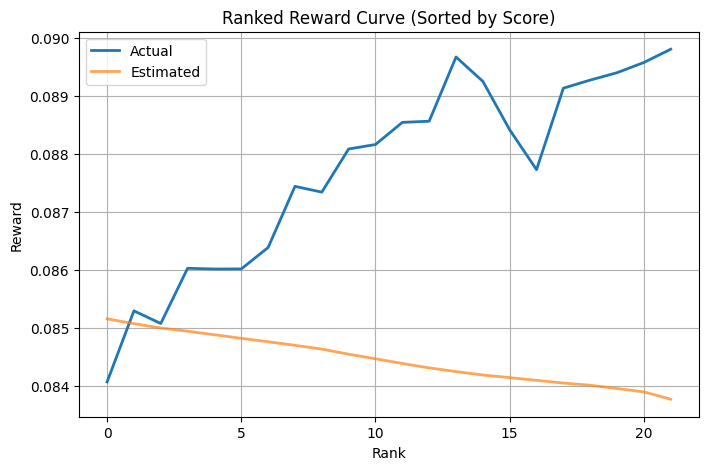

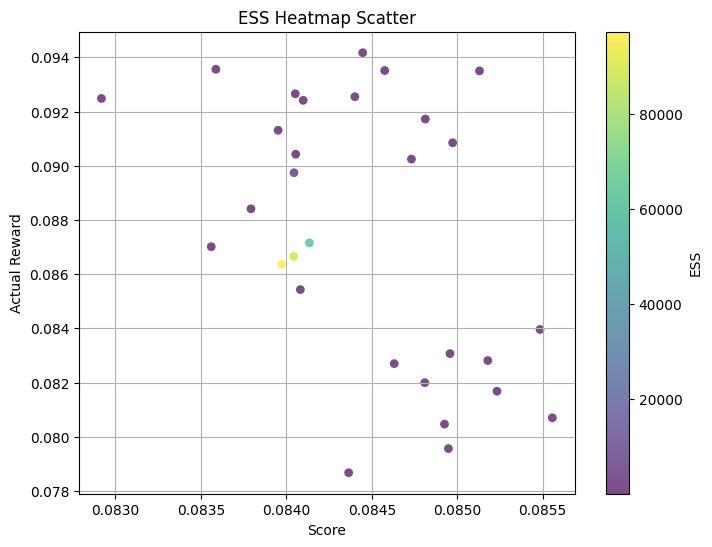

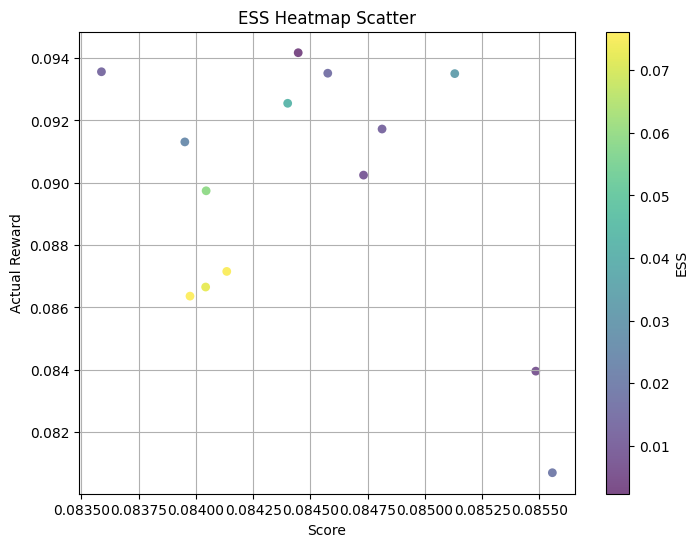

Correlation Metrics: {'pearson_score_actual': np.float64(-0.46582022043248006), 'spearman_score_actual': np.float64(-0.3975528364849833), 'spearman_est_actual': np.float64(-0.36774193548387096)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9690406512928065), 'ndcg_est_actual': np.float64(0.9715038956896959)}
Error Metrics: {'mean_error': np.float64(0.0028034133597965518), 'mae': np.float64(0.005143463469069096), 'rmse': np.float64(0.0058163120525822586), 'std_error': np.float64(0.005096112187455047), 'max_error': np.float64(0.009752254362599133), 'min_error': np.float64(-0.005725424559391512)}


In [ ]:
for val in np.arange(10000, 250000, 40000):
    train_dataset = generate_dataset(dataset_params, seed=val)

    # Run the optimization
    df_temp, study_df_temp = regression_trainer_trial(num_runs, num_neighbors, [val], train_dataset, batch_size, val_size=100000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

    study_df_temp.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{val}.csv")
    # Show the performance metrics
    display(df_temp[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_diff_to_real']])

    compute_statistics_and_plots(study_df_temp)